In [36]:
from pathlib import Path
import glob
import os
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk
import imageio.v2 as imageio
from PIL import Image

import torch
from torch import nn
import torchvision as TV
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.nn import UpsamplingNearest2d
from torch.nn.utils import spectral_norm
from torch.distributions import Normal
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

import utils
import u_net

path_data=r"C:\Users\Luuk\Desktop\TestData" # p119, p128, p135




In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Load the test data

In [3]:
# directory with test data
DATA_DIR = Path.cwd() / "TestData"
print(DATA_DIR)

patients = [
    path
    for path in glob.glob(path_data+r"\p*[0-9]")
]
print(len(patients))

partition = {
    "patient_1": patients[:1],
    "patient_2": patients[1:2],
    "patient_3": patients[2:3],
}


IMAGE_SIZE = [64, 64]
BATCH_SIZE = 32

# load test data
#test_dataset = utils.ProstateMRDataset(patients, IMAGE_SIZE)
dataset_p1 = utils.ProstateMRDataset(partition["patient_1"], IMAGE_SIZE)
dataset_p2 = utils.ProstateMRDataset(partition["patient_2"], IMAGE_SIZE)
dataset_p3 = utils.ProstateMRDataset(partition["patient_3"], IMAGE_SIZE)

# test_dataloader = DataLoader(
#     test_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
# )

C:\Users\Luuk\Desktop\TestData
3


### Evaluation metrics functions

In [4]:
# Dice score function
def diceFunction(im1, im2):
    '''
    Compute the dice score between two input images or volumes. Note that we use a smoothing factor of 1.
    :param im1: Image 1
    :param im2: Image 2
    :return: Dice score
    '''
    
    readable_im1 = imageio.imread(im1)
    readable_im2 = imageio.imread(im2)
    
    im1 = np.asarray(readable_im1).astype(bool)
    im2 = np.asarray(readable_im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return (2. * intersection.sum() + 1 ) / (im1.sum() + im2.sum() + 1)

In [5]:
# Hausdorff distance (among other metrics)
def computeQualityMeasures(im_pred, im_truth):
    """
    Computes multiple image registration evaluation measures, including dice score and Hausdorff distances.
    We can decide ourselves which ones we want.
    
    input:
    -im_pred: The predicted segmentation
    -im_truth: The ground truth
    
    output:
    dictionary containing:
    -average Hausdorff distance
    -maximum Hausdorff distance
    -95% Hausdorff distance
    (-dice score)
    (-volume similarity)
    (-false negative rate)
    (-false positive rate)
    (-mean surface distance)
    (-median surface distance)
    (-standard deviation surface distance)
    (-maximum surface distance)
    """
    readable_pred = imageio.imread(im_pred)
    readable_truth = imageio.imread(im_truth)
    
    quality=dict()
    labelPred=sitk.GetImageFromArray(readable_pred, isVector=False)
    labelTrue=sitk.GetImageFromArray(readable_truth, isVector=False)
    
    #Hausdorff Distance
    hausdorffcomputer=sitk.HausdorffDistanceImageFilter()
    hausdorffcomputer.Execute(labelTrue>0.5,labelPred>0.5)
    quality["avgHausdorff"]=hausdorffcomputer.GetAverageHausdorffDistance()
    quality["Hausdorff"]=hausdorffcomputer.GetHausdorffDistance()

    
    ##Dice,Jaccard,Volume Similarity..
    #dicecomputer.Execute(labelTrue>0.5,labelPred>0.5)
    #quality["dice"]=dicecomputer.GetDiceCoefficient()
    #quality["volume_similarity"]=dicecomputer.GetVolumeSimilarity()
    #quality["false_negative"]=dicecomputer.GetFalseNegativeError()
    #quality["false_positive"]=dicecomputer.GetFalsePositiveError()
    
    #Surface distance measures
    label = 1
    ref_distance_map=sitk.Abs(sitk.SignedMaurerDistanceMap(labelTrue>0.5,squaredDistance=False))
    ref_surface=sitk.LabelContour(labelTrue>0.5)
    statistics_image_filter=sitk.StatisticsImageFilter()
    statistics_image_filter.Execute(labelTrue>0.5)
    num_ref_surface_pixels=int(statistics_image_filter.GetSum())

    seg_distance_map=sitk.Abs(sitk.SignedMaurerDistanceMap(labelPred>0.5,squaredDistance=False))
    seg_surface=sitk.LabelContour(labelPred>0.5)
    seg2ref_distance_map=ref_distance_map*sitk.Cast(seg_surface,sitk.sitkFloat32)
    ref2seg_distance_map=seg_distance_map*sitk.Cast(ref_surface,sitk.sitkFloat32)
    
    statistics_image_filter.Execute(labelPred>0.5)
    num_seg_surface_pixels=int(statistics_image_filter.GetSum())

    seg2ref_distance_map_arr=sitk.GetArrayViewFromImage(seg2ref_distance_map)
    seg2ref_distances=list(seg2ref_distance_map_arr[seg2ref_distance_map_arr!=0])
    seg2ref_distances=seg2ref_distances+list(np.zeros(num_seg_surface_pixels-len(seg2ref_distances)))
    ref2seg_distance_map_arr=sitk.GetArrayViewFromImage(ref2seg_distance_map)
    ref2seg_distances=list(ref2seg_distance_map_arr[ref2seg_distance_map_arr!=0])
    ref2seg_distances=ref2seg_distances+list(np.zeros(num_ref_surface_pixels-len(ref2seg_distances)))

    all_surface_distances=seg2ref_distances+ref2seg_distances
    #quality["mean_surface_distance"]=np.mean(all_surface_distances)
    #quality["median_surface_distance"]=np.median(all_surface_distances)
    #quality["std_surface_distance"]=np.std(all_surface_distances)
    #quality["max_surface_distance"]=np.max(all_surface_distances)
    
    
    ### Find the distances to surface points of the contour.  Calculate in both directions         
    dist_seg = sitk.GetArrayViewFromImage(seg_distance_map)[sitk.GetArrayViewFromImage(ref_surface)==1]
    dist_ref = sitk.GetArrayViewFromImage(ref_distance_map)[sitk.GetArrayViewFromImage(seg_surface)==1]


    ### Find the 95% Distance for each direction and average        
    quality['hausdorff_95']= (np.percentile(dist_ref, 95) + np.percentile(dist_seg, 95)) / 2.0

    return quality

### Initializing the U-Net model with the weights after training


In [6]:
# initialise model with weights of training the U-Net model (run3 -> segmentation_model_weights)
BEST_EPOCH = 59 # epoch with the lowest validation loss
CHECKPOINTS_DIR = Path.cwd() / "run3/segmentation_model_weights" / f"u_net_{BEST_EPOCH}.pth" 
print(CHECKPOINTS_DIR)

#initialise model with weights of resnet
unet_model = u_net.UNet(num_classes=1)
unet_model.load_state_dict(torch.load(CHECKPOINTS_DIR))

C:\Users\Luuk\Desktop\run3\segmentation_model_weights\u_net_59.pth


<All keys matched successfully>

In [7]:
print(len(dataset_p1))
print(len(dataset_p2))
print(len(dataset_p3))

86
86
86


### Use the U-Net for the test dataset: p119, p128, p135

### Patient 1

In [76]:
# U-Net with patient 1
# set model to evaluation mode
unet_model.eval()

results_folder_1 = r'C:\Users\Luuk\Desktop\Results\Patient_1'

with torch.no_grad():
    for predict_index in range(86):
        (input, target) = dataset_p1[predict_index]
        output = torch.sigmoid(unet_model(input[np.newaxis, ...]))
        prediction = torch.round(output)
        
        # each image and mask should be saved in 2D
        predicted_mask = sitk.GetImageFromArray(prediction[0, 0])
        path_mask = results_folder_1 + '\{}_mask_2D.mhd'.format(predict_index)
        sitk.WriteImage(predicted_mask, path_mask)
        ground_truth = sitk.GetImageFromArray(target[0])
        path_ground_truth = results_folder_1 + '\{}_ground_truth_2D.mhd'.format(predict_index)
        sitk.WriteImage(ground_truth, path_ground_truth)
        MR_image = sitk.GetImageFromArray(input[0])
        path_image = results_folder_1 + '\{}_image_2D.mhd'.format(predict_index)
        sitk.WriteImage(MR_image, path_image)
        
        # display the images, will also be done in the next cell, so commented here
#         fig, ax = plt.subplots(1, 3)
#         ax[0].imshow(input[0], cmap="gray")
#         ax[0].set_title("Input")
#         ax[0].axis("off")

#         ax[1].imshow(target[0], cmap="gray")
#         ax[1].set_title("Ground-truth")
#         ax[1].axis("off")

#         ax[2].imshow(prediction[0, 0], cmap="gray")
#         ax[2].set_title("Prediction")
#         ax[2].axis("off")
#         plt.show()
        

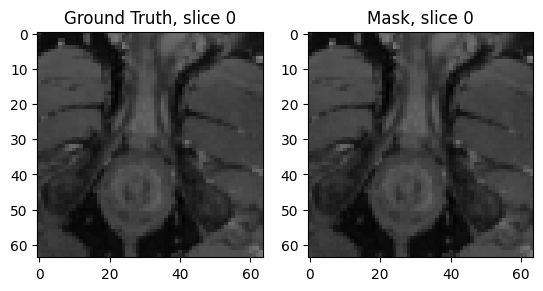

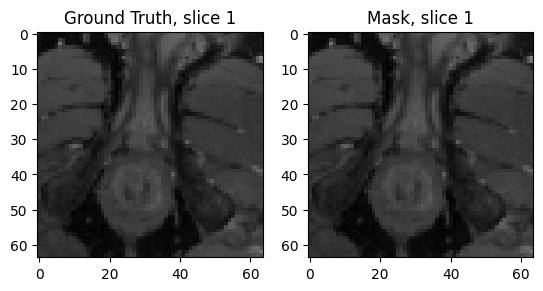

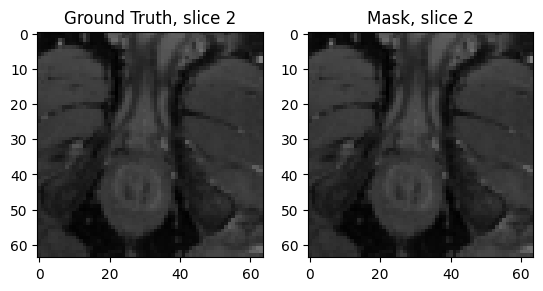

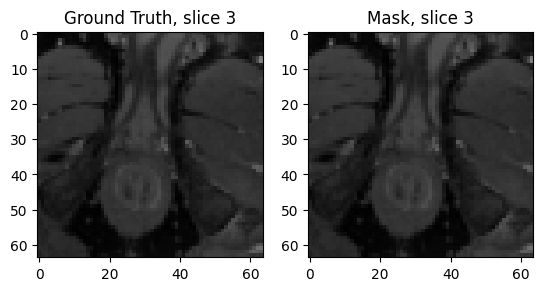

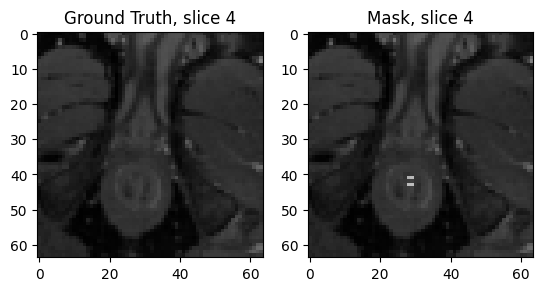

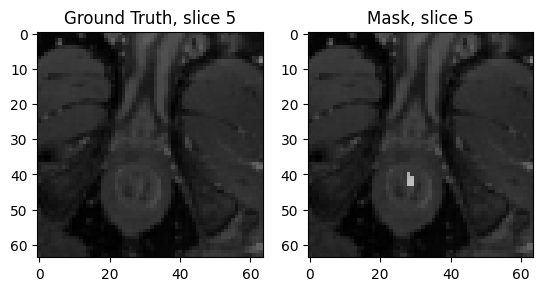

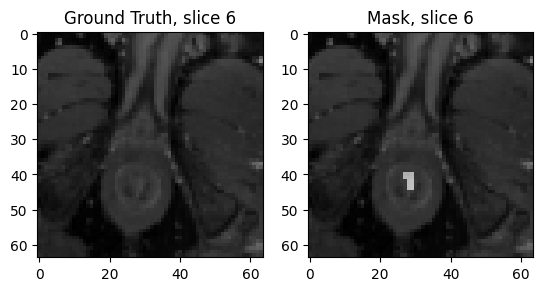

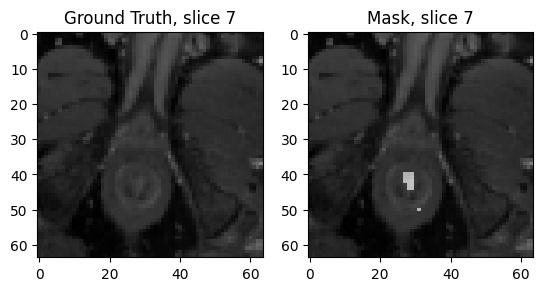

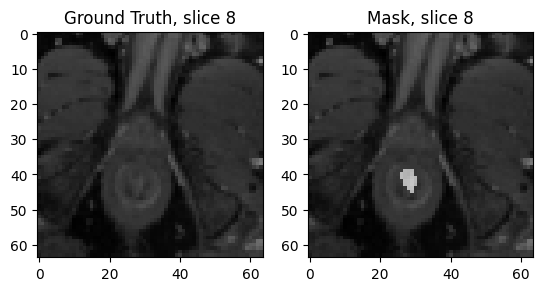

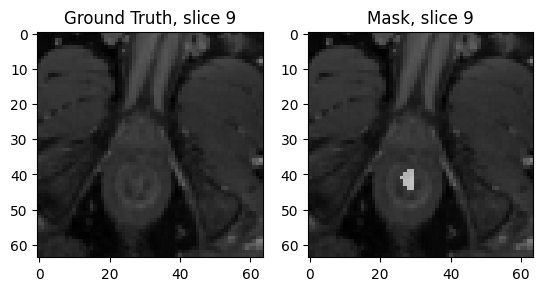

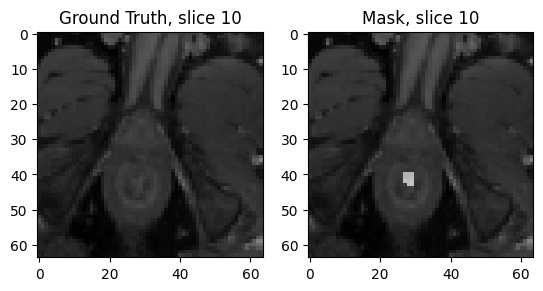

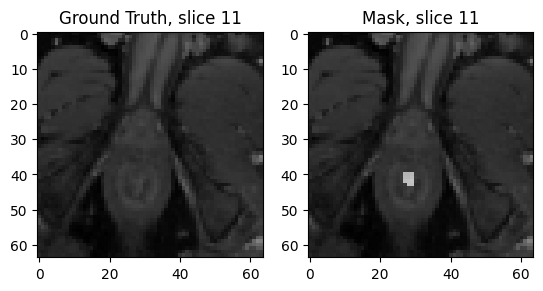

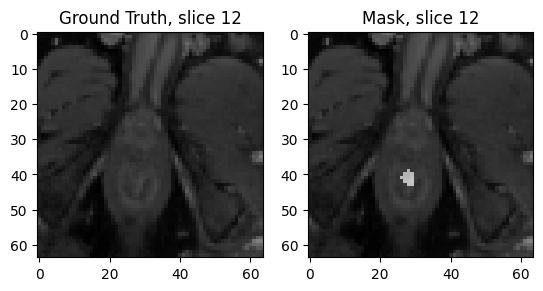

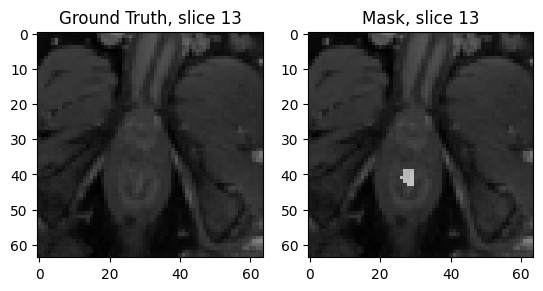

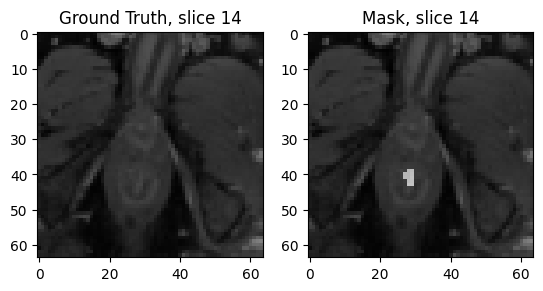

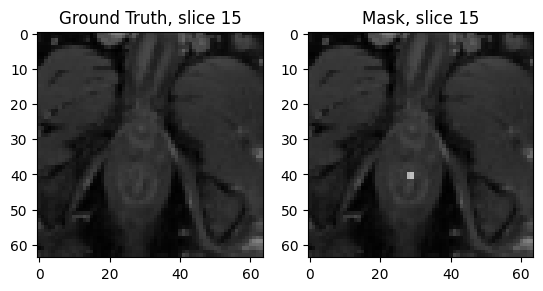

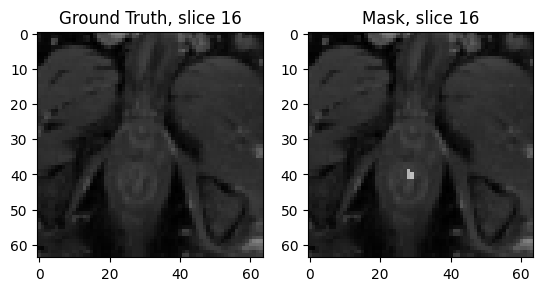

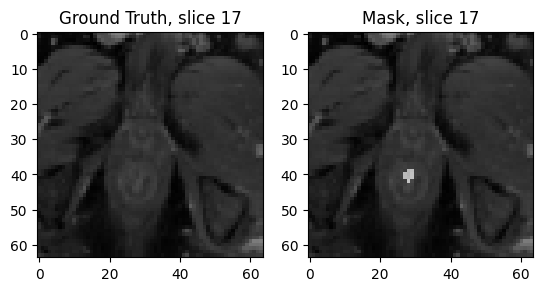

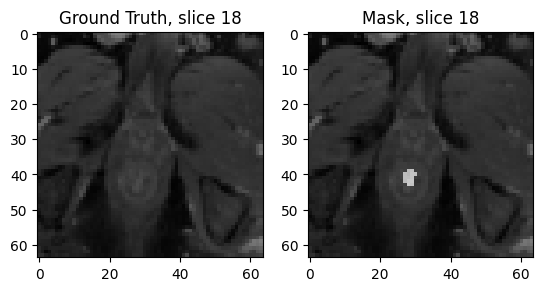

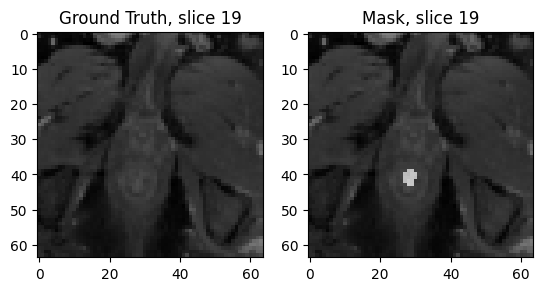

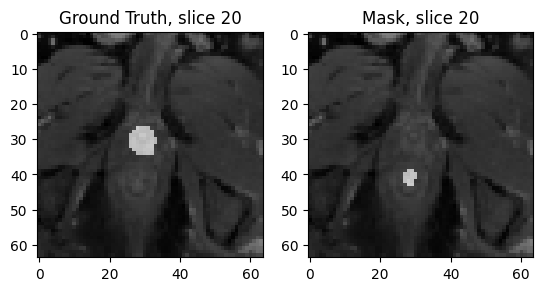

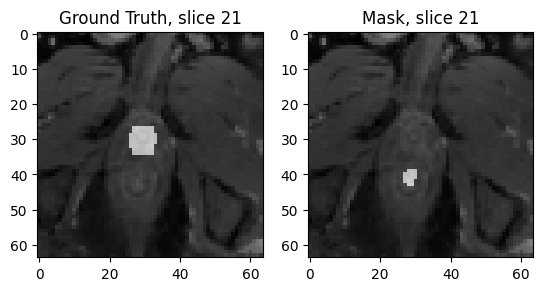

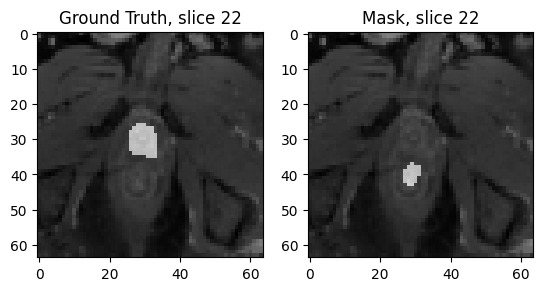

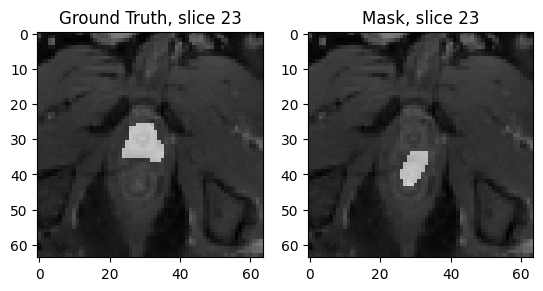

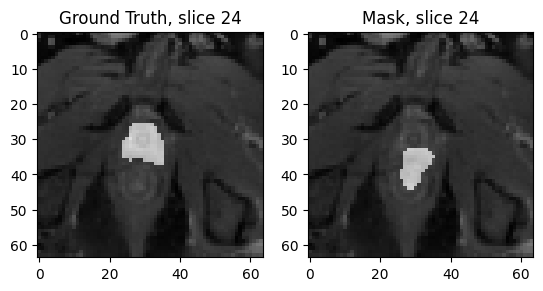

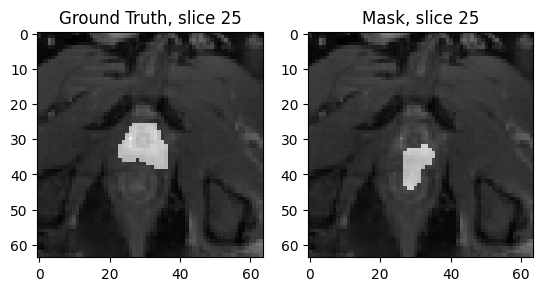

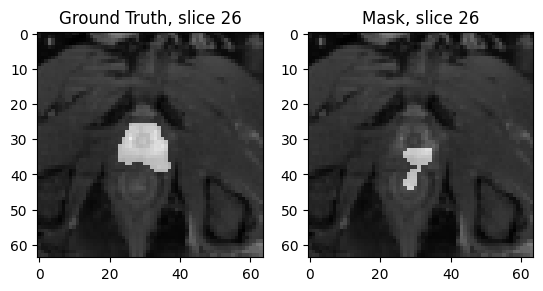

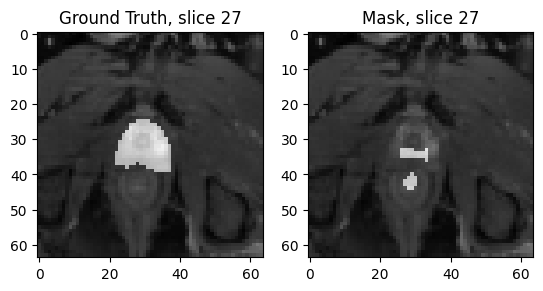

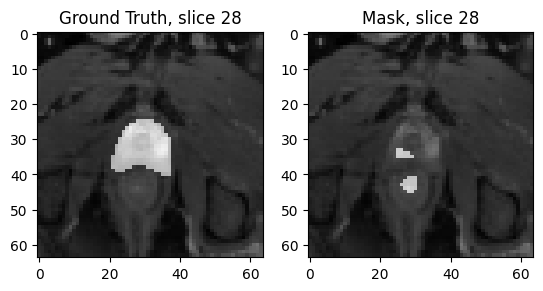

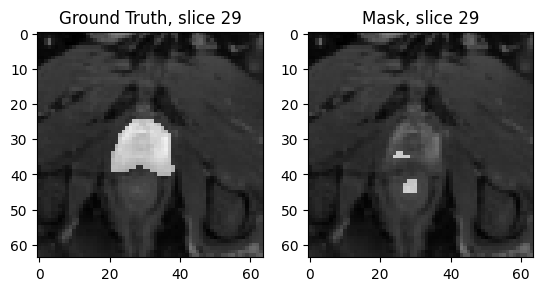

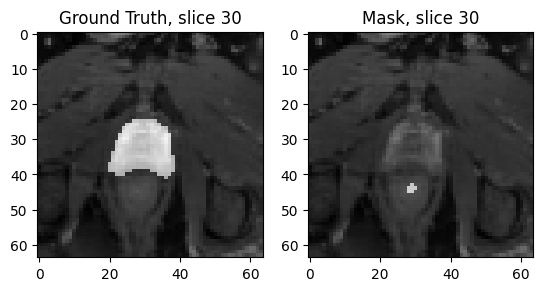

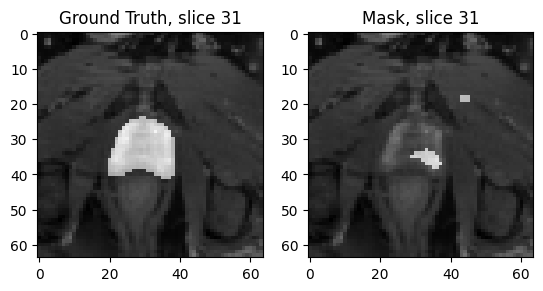

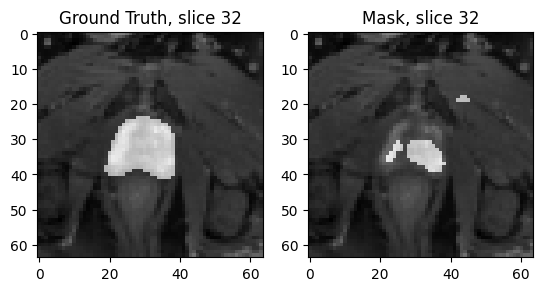

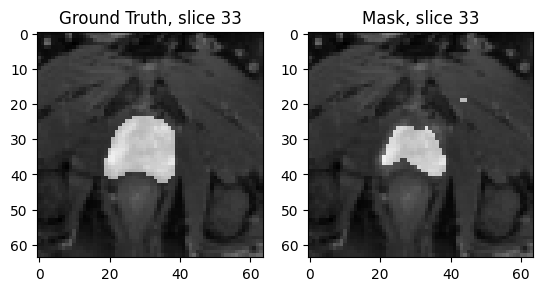

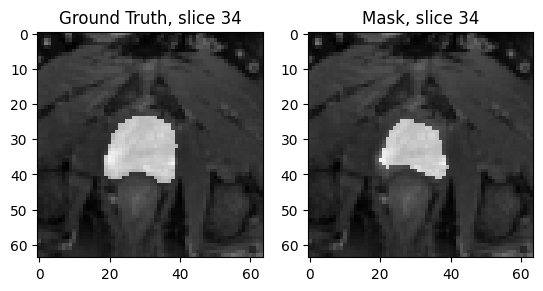

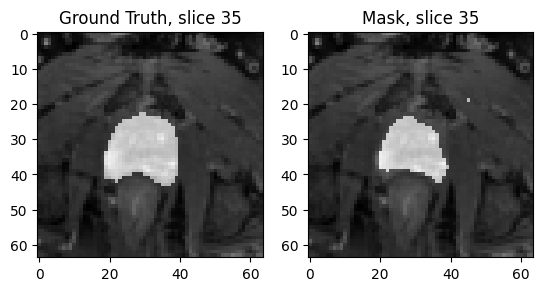

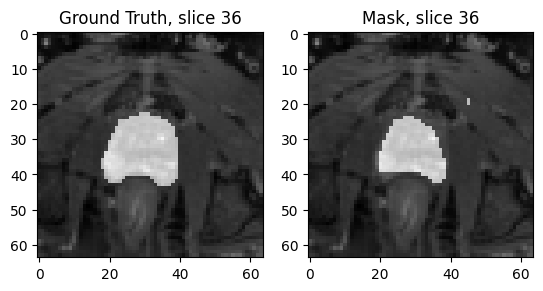

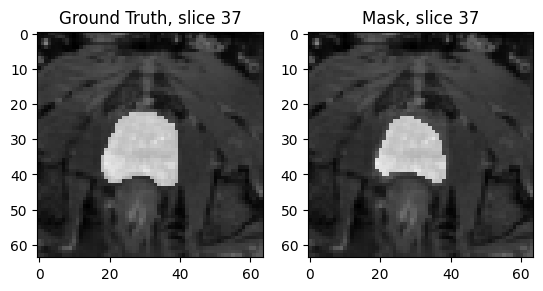

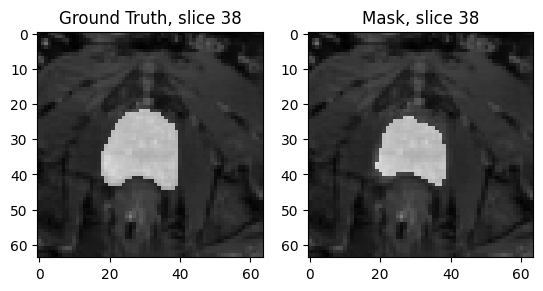

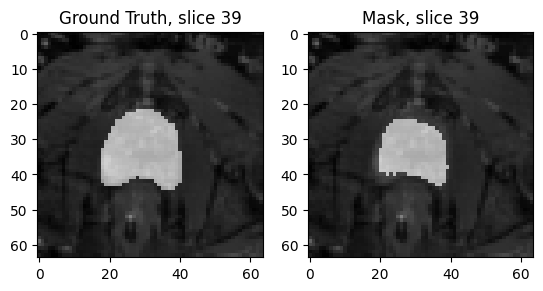

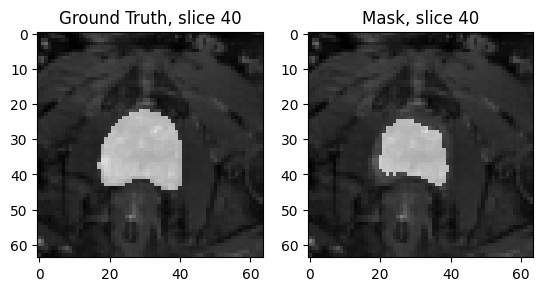

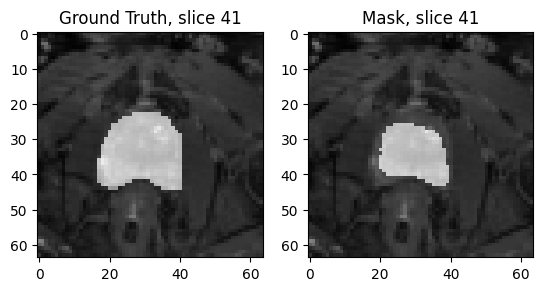

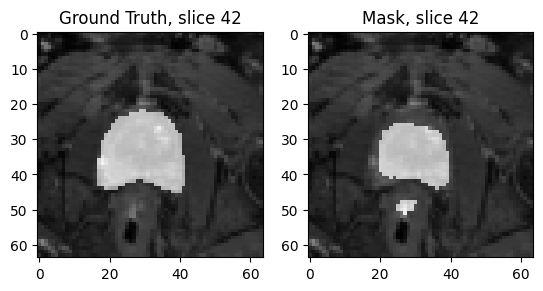

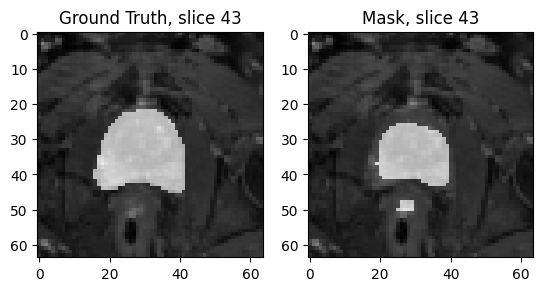

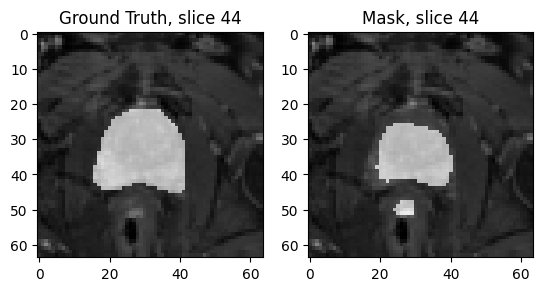

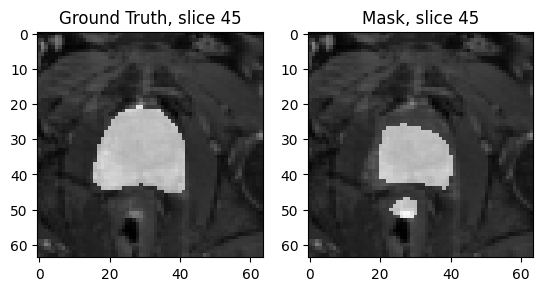

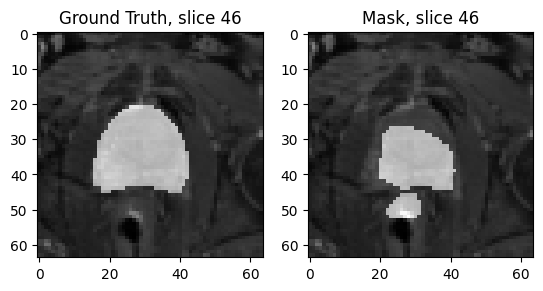

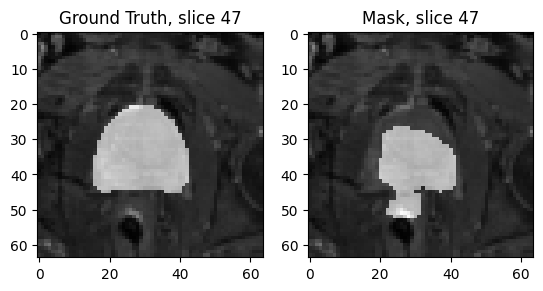

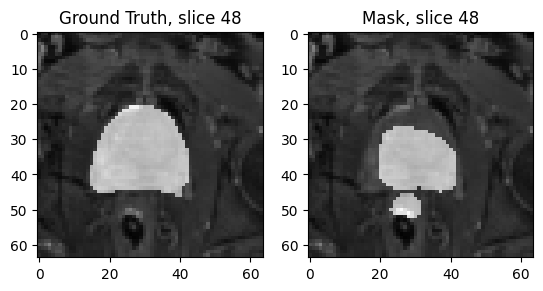

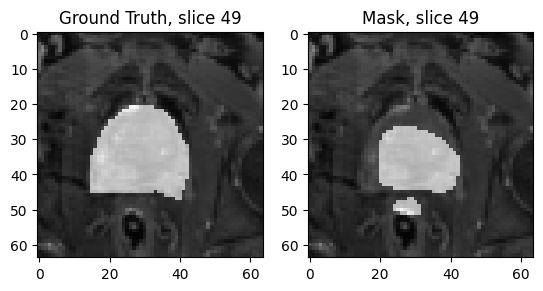

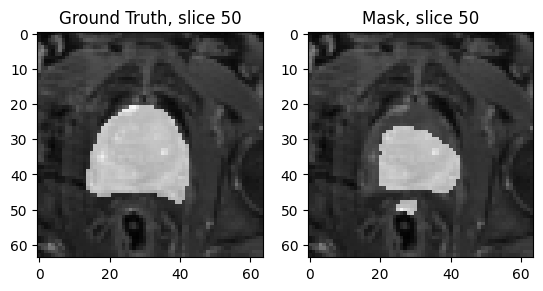

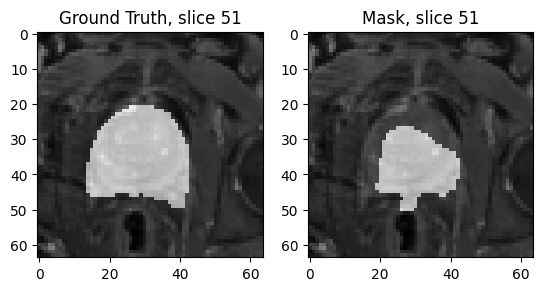

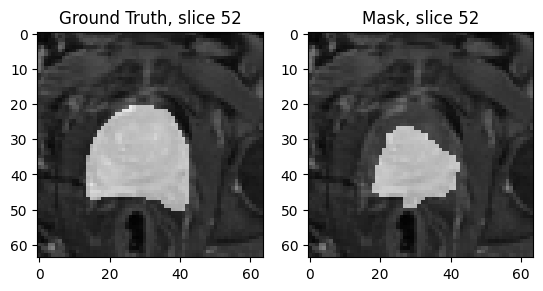

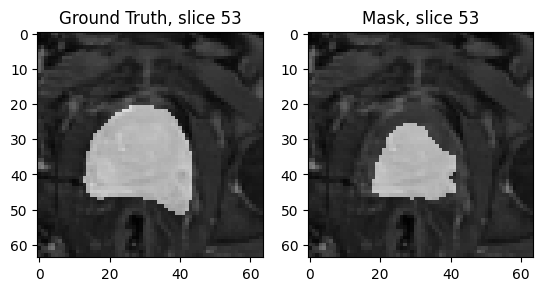

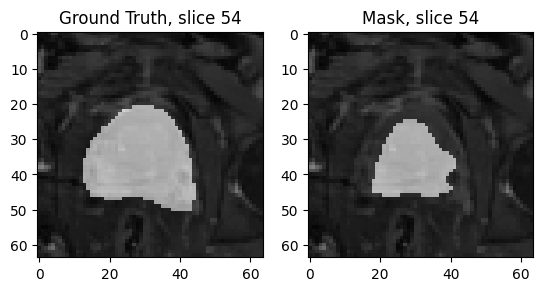

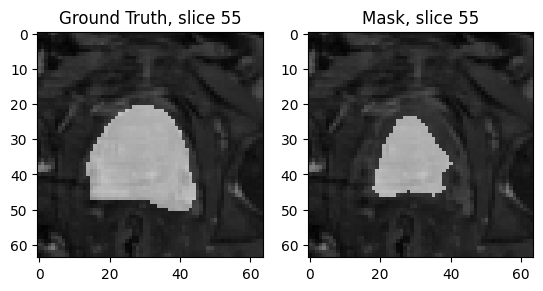

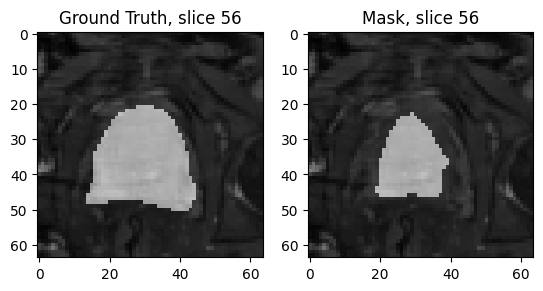

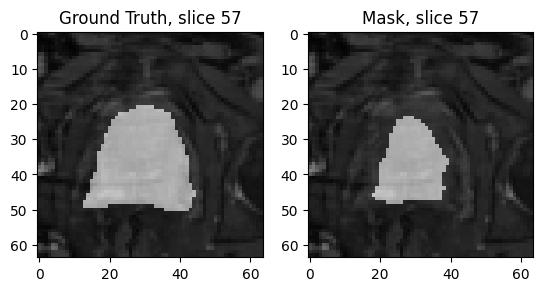

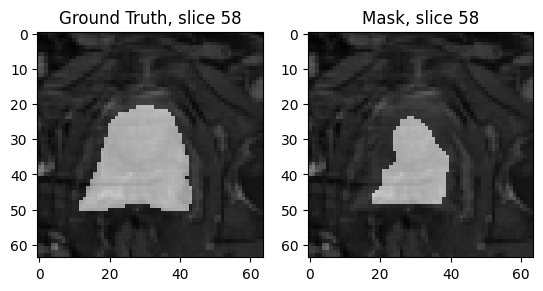

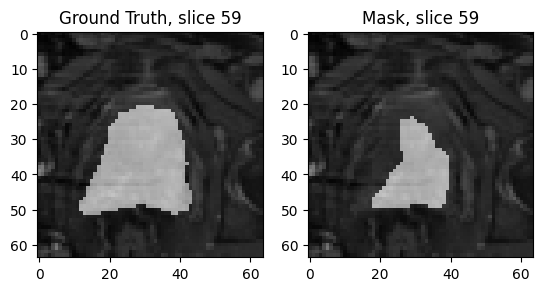

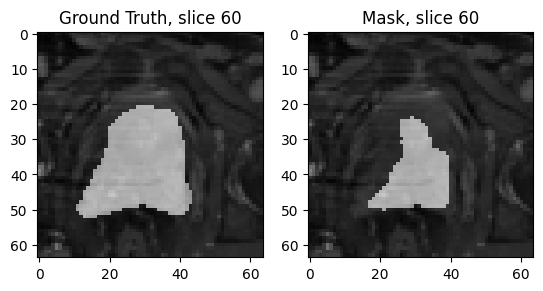

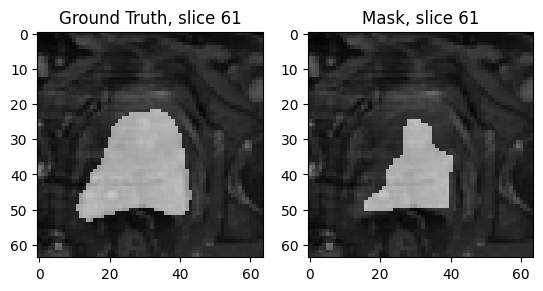

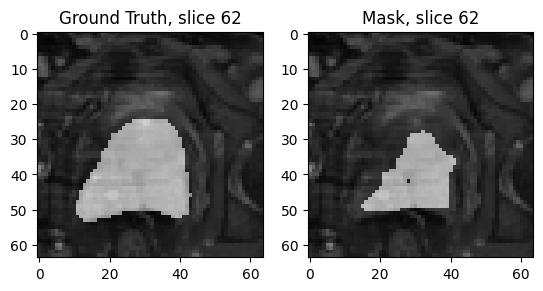

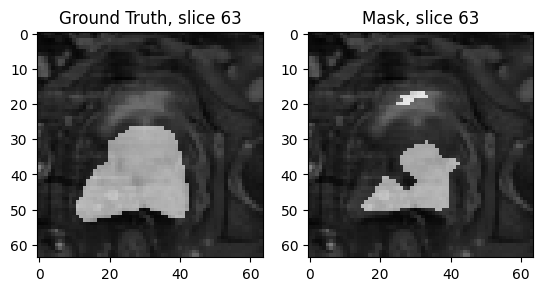

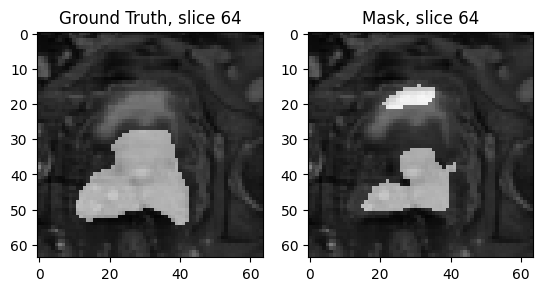

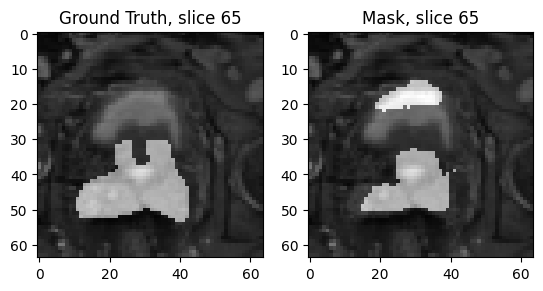

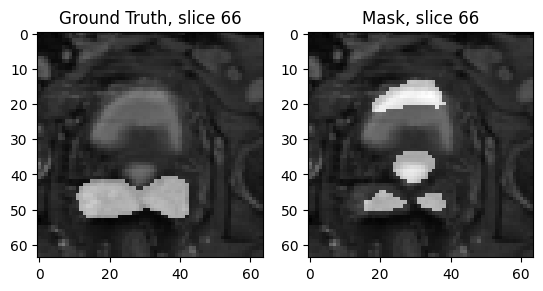

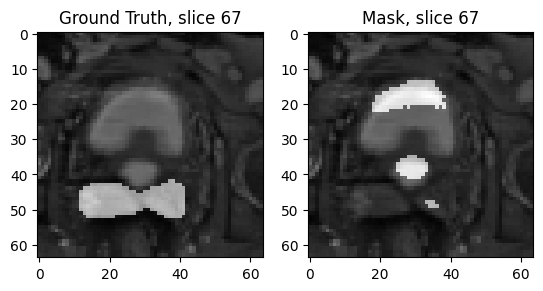

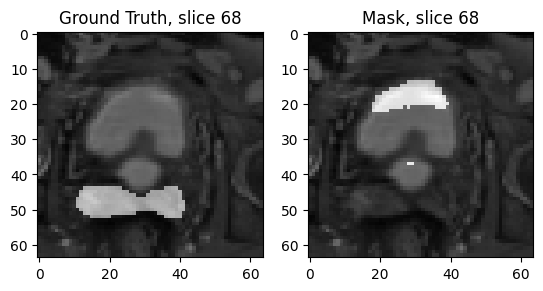

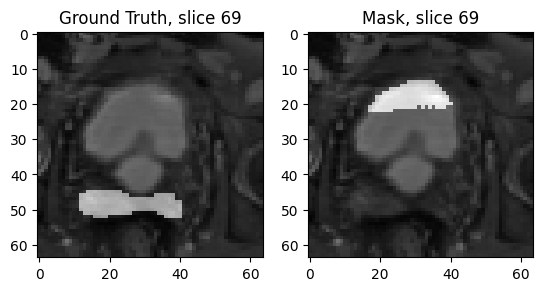

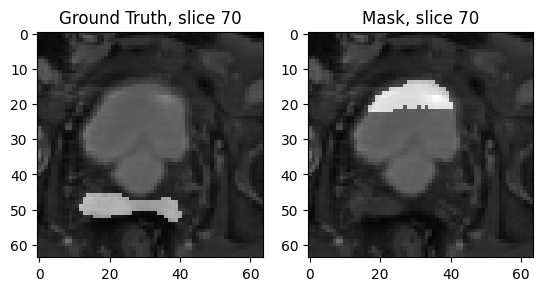

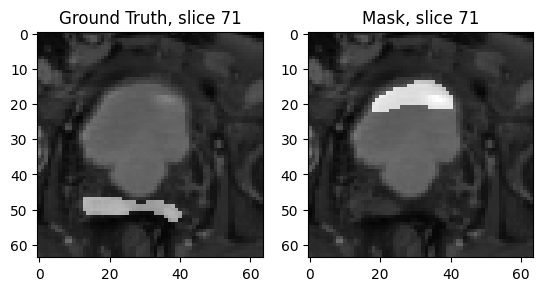

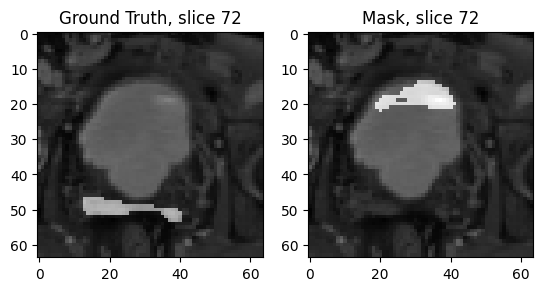

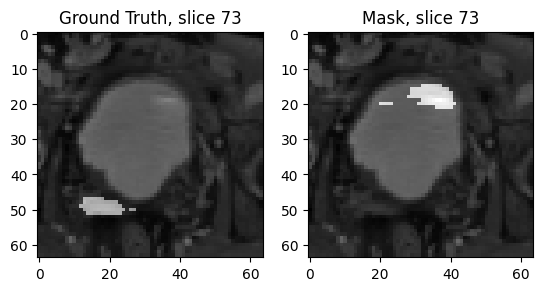

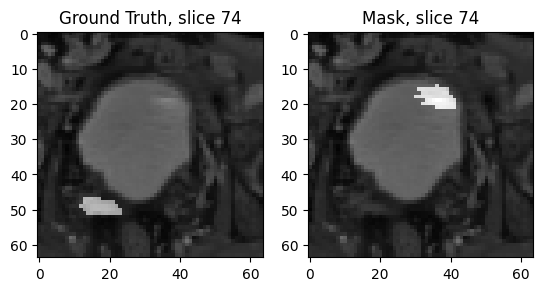

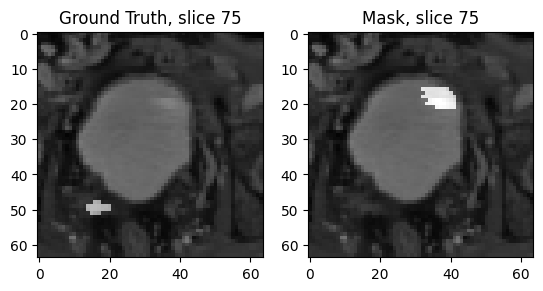

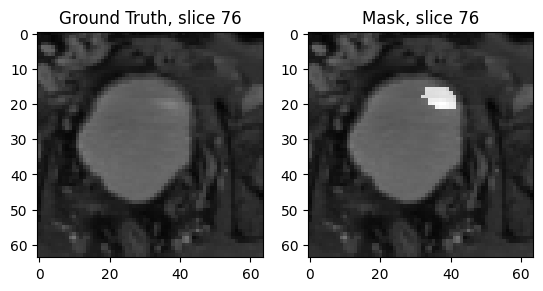

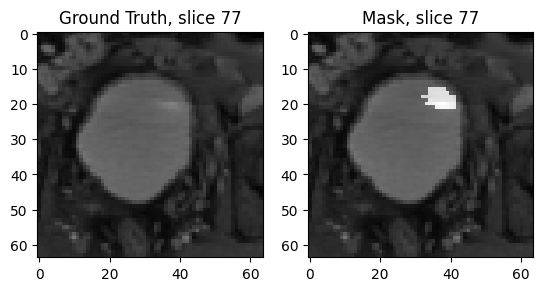

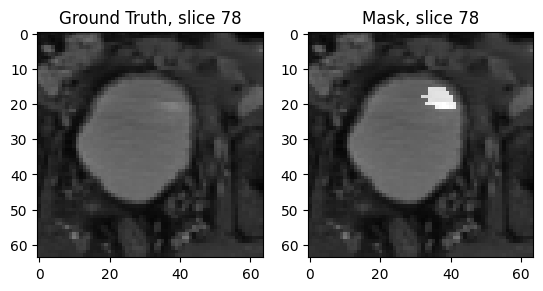

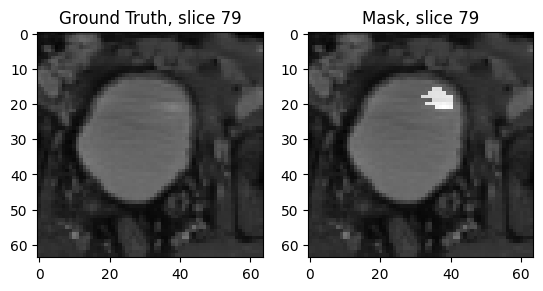

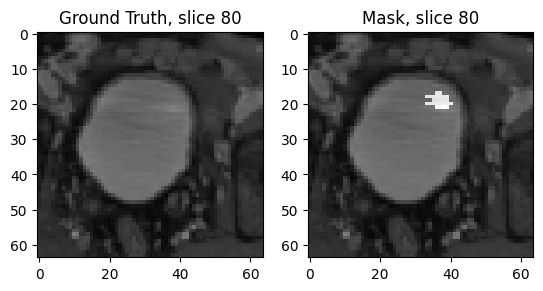

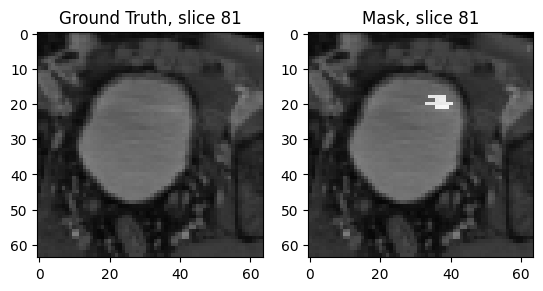

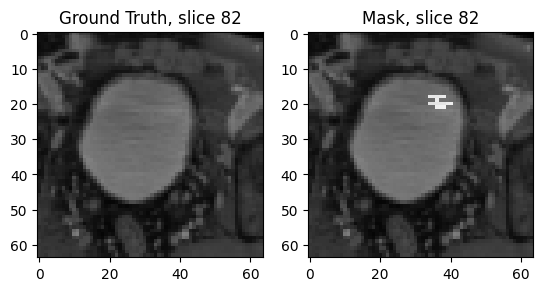

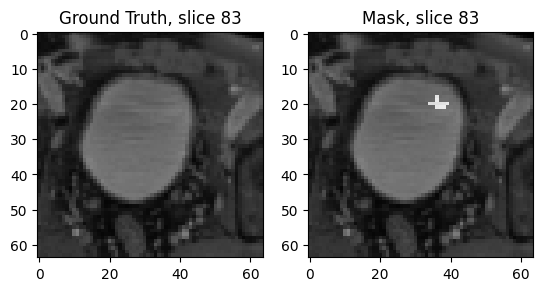

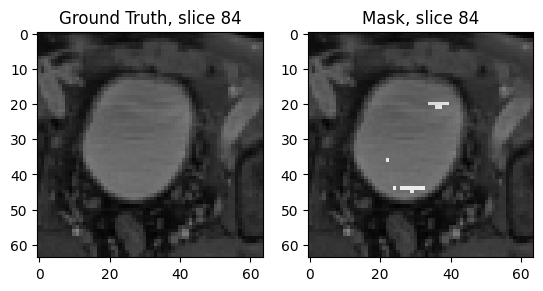

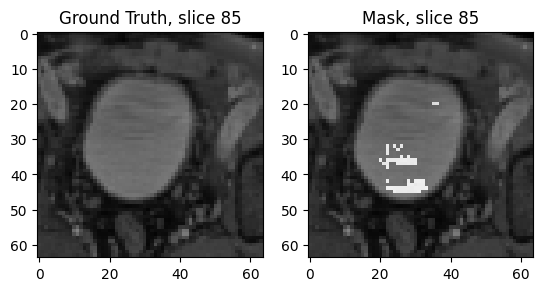

In [79]:
# Use the 2D images that are saved to create 3D
mask_3D = []
ground_truth_3D = []
image_3D = []
for predict_index in range(86):
    read_path_mask = results_folder_1 + '\{}_mask_2D.mhd'.format(predict_index)
    read_mask = sitk.ReadImage(read_path_mask)
    array_mask = sitk.GetArrayFromImage(read_mask)
    mask_3D.append(array_mask)
    
    read_path_ground_truth = results_folder_1 + '\{}_ground_truth_2D.mhd'.format(predict_index)
    read_ground_truth = sitk.ReadImage(read_path_ground_truth)
    array_ground_truth = sitk.GetArrayFromImage(read_ground_truth)
    ground_truth_3D.append(array_ground_truth)
    
    read_path_image = results_folder_1 + '\{}_image_2D.mhd'.format(predict_index)
    read_image = sitk.ReadImage(read_path_image)
    array_image = sitk.GetArrayFromImage(read_image)
    image_3D.append(array_image)

save_path_mask = results_folder_1 + '\mask_3D.mhd'
save_mask_3D = sitk.GetImageFromArray(mask_3D)
sitk.WriteImage(save_mask_3D,save_path_mask)

save_path_ground_truth = results_folder_1 + '\ground_truth_3D.mhd'
save_ground_truth_3D = sitk.GetImageFromArray(ground_truth_3D)
sitk.WriteImage(save_ground_truth_3D,save_path_ground_truth)

save_path_image = results_folder_1 + '\image_3D.mhd'
save_image_3D = sitk.GetImageFromArray(image_3D)
sitk.WriteImage(save_image_3D,save_path_image)

mask_result = sitk.ReadImage(save_path_mask)
mask_array_result = sitk.GetArrayFromImage(mask_result)

ground_truth_result = sitk.ReadImage(save_path_ground_truth)
ground_truth_array_result = sitk.GetArrayFromImage(ground_truth_result)

image_result = sitk.ReadImage(save_path_image)
image_array_result = sitk.GetArrayFromImage(image_result)

# show each slice of the 3D image, 
for i in range(86):
    # Overlay ground truth on MR image & predicted mask on MR image
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image_array_result[i,:,:], cmap="gray")
    ax[0].imshow(ground_truth_array_result[i,:,:], cmap="gray", alpha=0.5)
    ax[0].set_title("Ground Truth, slice {}".format(i))
    ax[1].imshow(image_array_result[i,:,:], cmap="gray")
    ax[1].imshow(mask_array_result[i,:,:], cmap="gray", alpha=0.5)
    ax[1].set_title("Mask, slice {}".format(i))
    
    plt.show()
    
    
    

In [ ]:
# path_image = r'C:\Users\Luuk\Desktop\TestData\p119\mr_bffe.mhd' # folder to p1 of test set
# #MR_image = sitk.ReadImage(dataset_p1)
# MR_image = sitk.ReadImage(path_image)
# dimension_MR = MR_image.GetDimension()
# print(dimension_MR)
# size_mr = MR_image.GetSize()
# print(size_mr)
# origin_MR = MR_image.GetOrigin()
# direction_MR = MR_image.GetDirection()
# spacing_MR = MR_image.GetSpacing()
# new_size = [64, 64, 86]
# new_image = sitk.Image(new_size, MR_image.GetPixelIDValue())
# new_image.SetOrigin(origin_MR)
# new_image.SetSpacing(spacing_MR)
# new_image.SetDirection(direction_MR)

# new_center = np.array(new_image.TransformContinuousIndexToPhysicalPoint(np.array(new_image.GetSize())/2.0))
# transform = sitk.AffineTransform(dimension_MR)
# transform.SetMatrix(MR_image.GetDirection())
# transform.SetTranslation(np.array(MR_image.GetOrigin()) - origin_MR)

# centering_transform = sitk.TranslationTransform(dimension_MR)
# img_center = np.array(MR_image.TransformContinuousIndexToPhysicalPoint(np.array(MR_image.GetSize())/2.0))
# centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - new_center))
# centered_transform = sitk.Transform(transform)
# #centered_transform.AddTransform(centering_transform)
# centered_transform = sitk.CompositeTransform([centering_transform])

# #new_image.CopyInformation(MR_image)
# #show_new_image = 
# sitk.Resample(MR_image, new_image, centered_transform, sitk.sitkLinear, 0.0)
# MR_image_array = sitk.GetArrayFromImage(new_image)
# size_new = new_image.GetSize()
# print(size_new)

In [ ]:
# path_image = r'C:\Users\Luuk\Desktop\TestData\p119\mr_bffe.mhd' # folder to p1 of test set

# MR_image = sitk.ReadImage(path_image)
# #new_size = [8,8]
# img_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize(64),
#     transforms.CenterCrop(64),
#     transforms.ToTensor()
# ])
# MR_image_array = sitk.GetArrayFromImage(new_image)
# new_image = img_transform(MR_image_array)
# #MR_image_array = sitk.GetArrayFromImage(new_image)

In [11]:
# Calculate the Dice score and HD
p1_dice_coeffs=[]
p1_hausdorff_95=[]
p1_both_black=0
p1_one_black = 0

for slice_id in range(86):
    mask_path = results_folder_1+ '\{}_mask_2D.mhd'.format(slice_id)
    ground_truth_path = results_folder_1+ '\{}_ground_truth_2D.mhd'.format(slice_id)
        
    dice_coeff= diceFunction(ground_truth_path, mask_path)
    p1_dice_coeffs.append(dice_coeff)
        
    #get extrema ground truth
    readable_ground_truth = imageio.imread(ground_truth_path)
    gt_result = Image.fromarray(readable_ground_truth)
    extrema_result = gt_result.getextrema()
        
    #get extrema predicted mask
    readable_mask = imageio.imread(mask_path)
    mask_result = Image.fromarray(readable_mask)
    extrema_orig = mask_result.getextrema()
             
    # do not calculate Hausdorff distance if segmentation is black
    if extrema_result[1]== 0 and extrema_orig[1]==0:
        p1_both_black += 1

    else:
        if extrema_result[1] == 0 and extrema_orig[1] != 0:
            p1_one_black += 1
        if extrema_result[1] != 0 and extrema_orig[1] == 0:
            p1_one_black += 1
                
    if extrema_result[0] != extrema_result[1] and extrema_orig[1] != 0:
        quality= computeQualityMeasures(ground_truth_path, mask_path)
        p1_hausdorff_95.append(quality.get('hausdorff_95'))

print("These are the results for patient 1")
print(p1_both_black, "both black")
print(p1_one_black, "one black")

p1_avg_dice= np.mean(p1_dice_coeffs)
p1_avg_hausdorff_95=np.mean(p1_hausdorff_95)
print(p1_dice_coeffs, "Dice")
print(p1_avg_dice, "Average dice")
print(p1_hausdorff_95, "HD 95")
print(p1_avg_hausdorff_95, "Average HD 95")

These are the results for patient 1
4 both black
26 one black
[1.0, 1.0, 1.0, 1.0, 0.2, 0.125, 0.07692307692307693, 0.06666666666666667, 0.041666666666666664, 0.05555555555555555, 0.08333333333333333, 0.08333333333333333, 0.07142857142857142, 0.0625, 0.07692307692307693, 0.2, 0.16666666666666666, 0.1, 0.06666666666666667, 0.0625, 0.014925373134328358, 0.013888888888888888, 0.010869565217391304, 0.17647058823529413, 0.324468085106383, 0.36666666666666664, 0.3317307692307692, 0.2102803738317757, 0.09871244635193133, 0.06276150627615062, 0.004149377593360996, 0.1903114186851211, 0.45879120879120877, 0.7259100642398287, 0.8218390804597702, 0.8295652173913044, 0.8308457711442786, 0.8367346938775511, 0.8335809806835067, 0.8037518037518038, 0.770893371757925, 0.7645390070921986, 0.7613488975356679, 0.755359394703657, 0.7460701330108828, 0.7256740914419695, 0.6913716814159292, 0.7044491525423728, 0.7216386554621849, 0.7303370786516854, 0.7165829145728643, 0.7042389210019268, 0.7042910447761194

### Patient 2

In [80]:
# U-Net with patient 2
# set model to evaluation mode
unet_model.eval()

results_folder_2 = r'C:\Users\Luuk\Desktop\Results\Patient_2'

with torch.no_grad():
    for predict_index in range(86):
        (input, target) = dataset_p2[predict_index]
        output = torch.sigmoid(unet_model(input[np.newaxis, ...]))
        prediction = torch.round(output)
        
        # each image and mask should be saved in 2D
        predicted_mask = sitk.GetImageFromArray(prediction[0, 0])
        path_mask = results_folder_2 + '\{}_mask_2D.mhd'.format(predict_index)
        sitk.WriteImage(predicted_mask, path_mask)
        ground_truth = sitk.GetImageFromArray(target[0])
        path_ground_truth = results_folder_2 + '\{}_ground_truth_2D.mhd'.format(predict_index)
        sitk.WriteImage(ground_truth, path_ground_truth)
        MR_image = sitk.GetImageFromArray(input[0])
        path_image = results_folder_2 + '\{}_image_2D.mhd'.format(predict_index)
        sitk.WriteImage(MR_image, path_image)
        
        # display the images, will also be done in the next cell, so commented here
#         fig, ax = plt.subplots(1, 3)
#         ax[0].imshow(input[0], cmap="gray")
#         ax[0].set_title("Input")
#         ax[0].axis("off")

#         ax[1].imshow(target[0], cmap="gray")
#         ax[1].set_title("Ground-truth")
#         ax[1].axis("off")

#         ax[2].imshow(prediction[0, 0], cmap="gray")
#         ax[2].set_title("Prediction")
#         ax[2].axis("off")
#         plt.show()
        

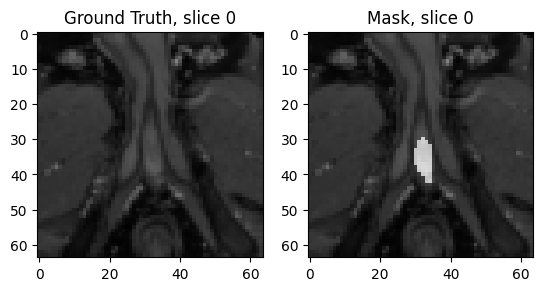

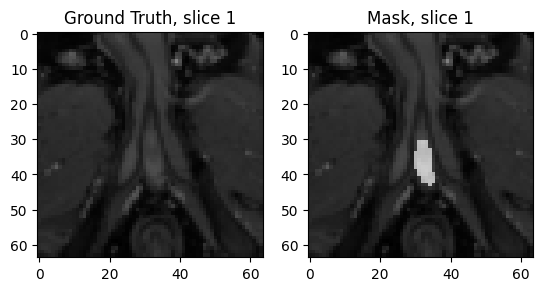

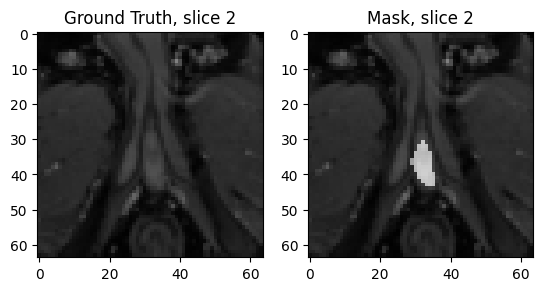

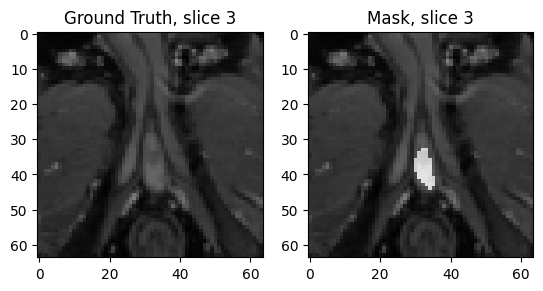

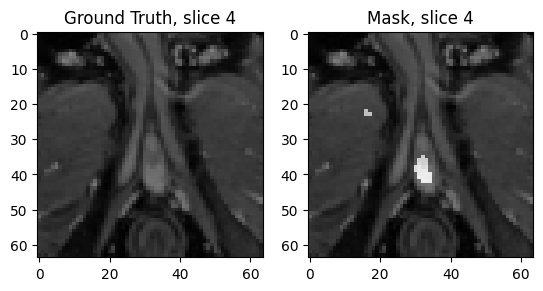

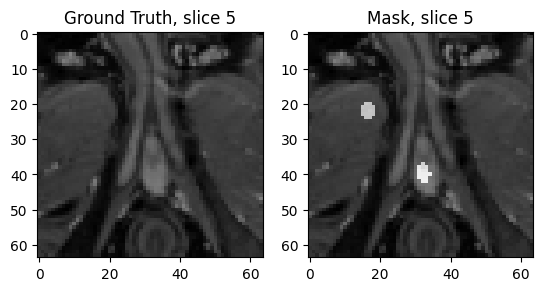

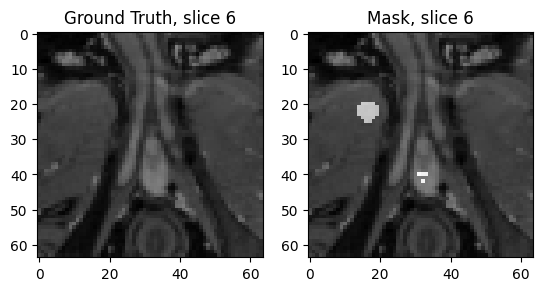

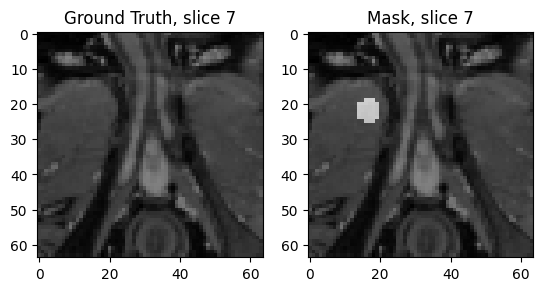

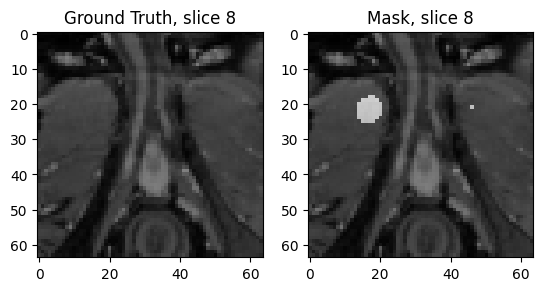

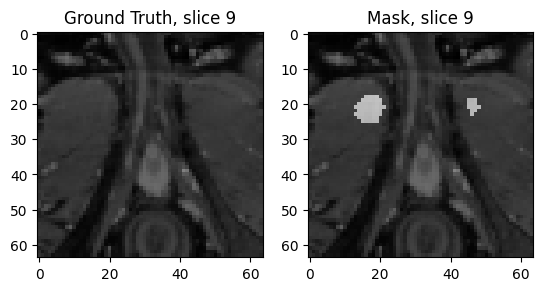

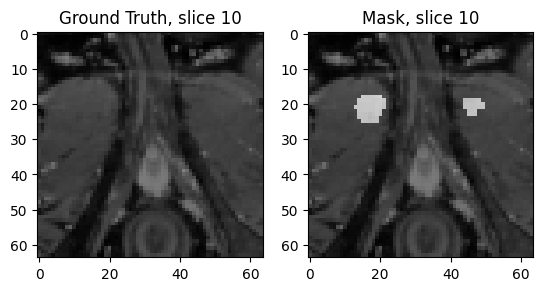

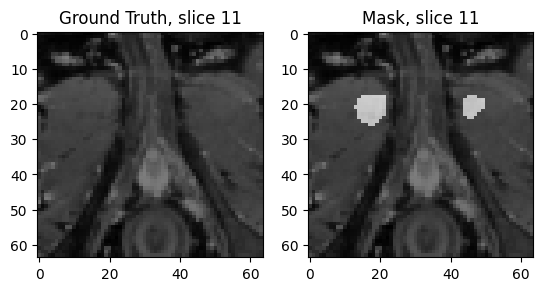

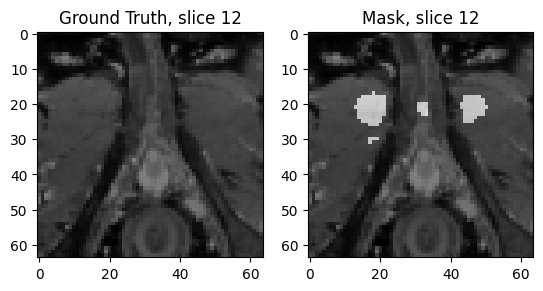

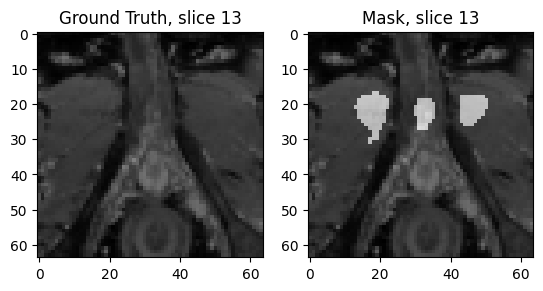

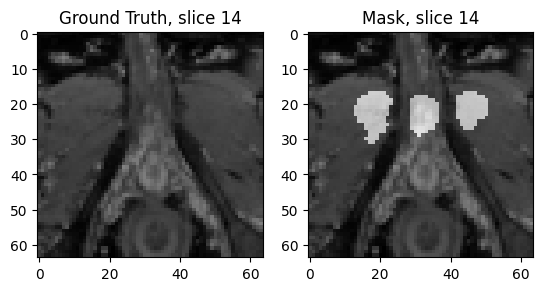

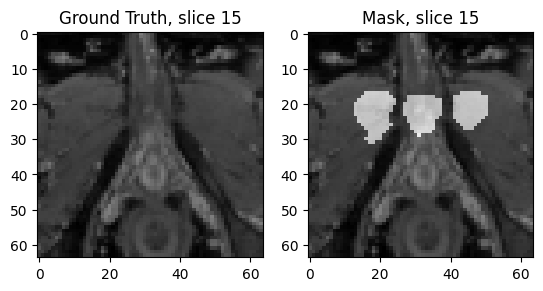

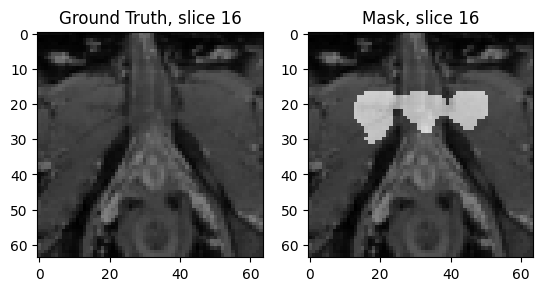

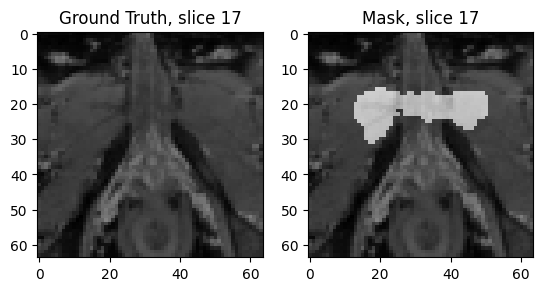

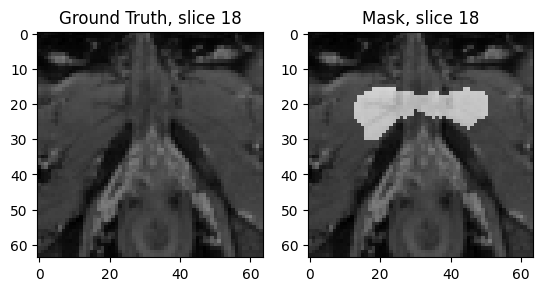

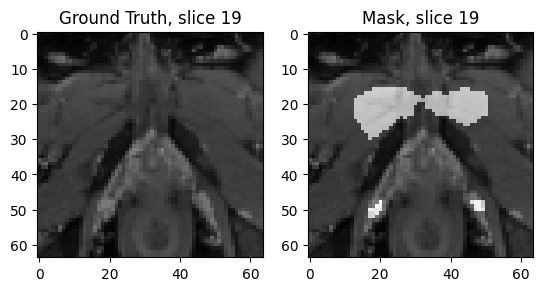

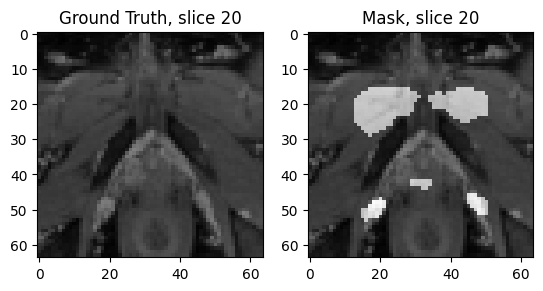

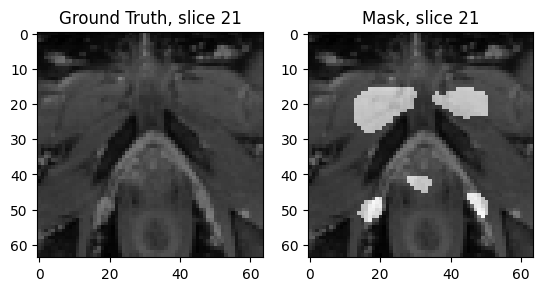

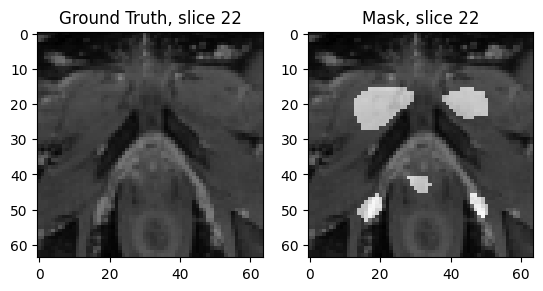

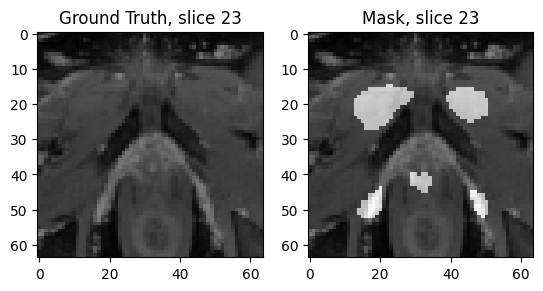

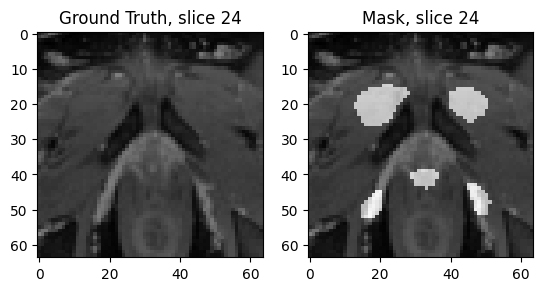

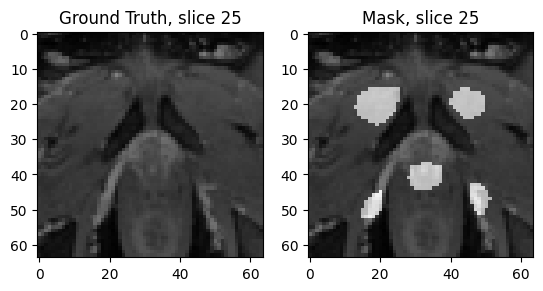

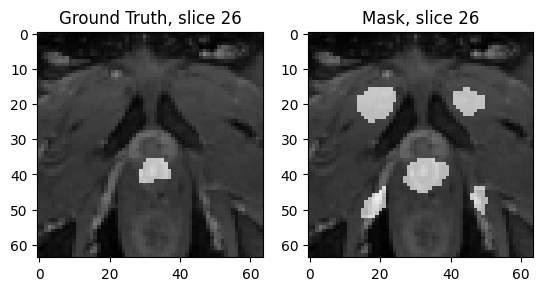

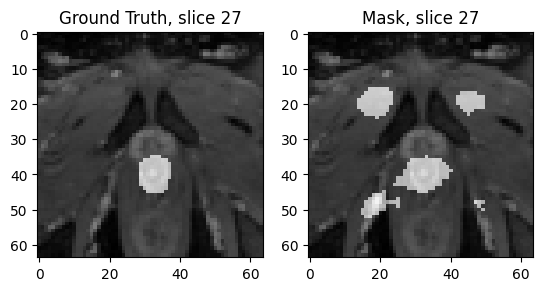

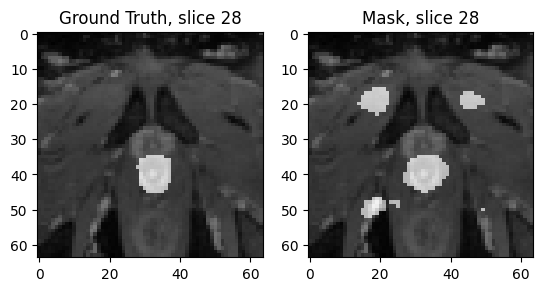

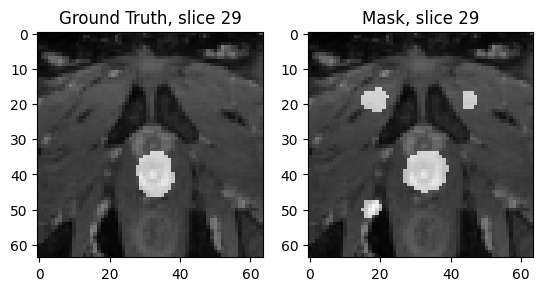

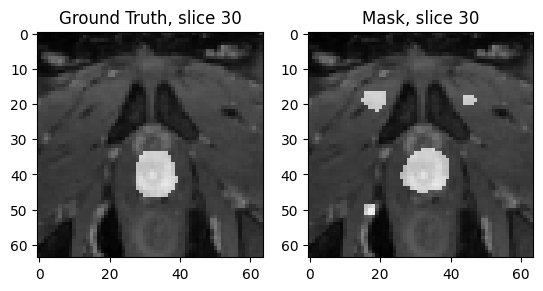

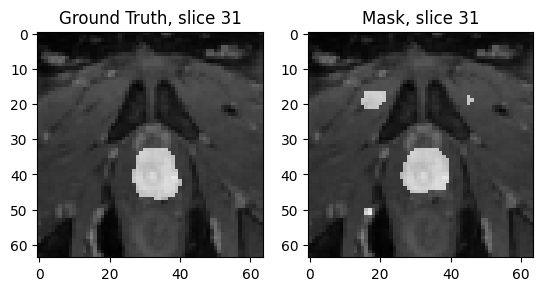

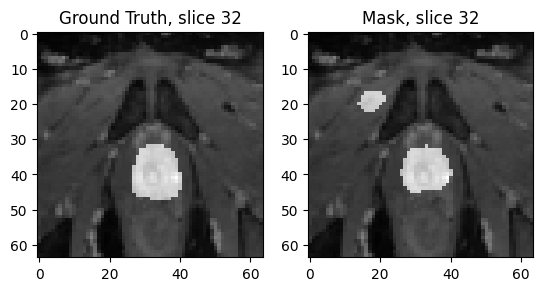

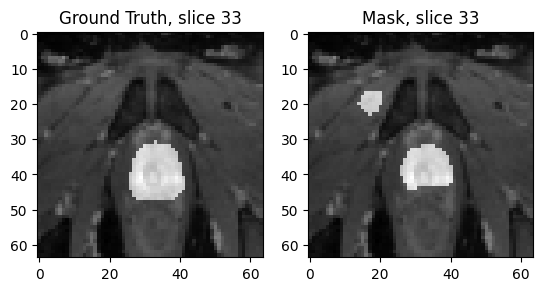

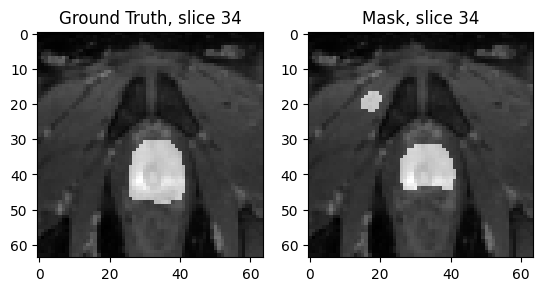

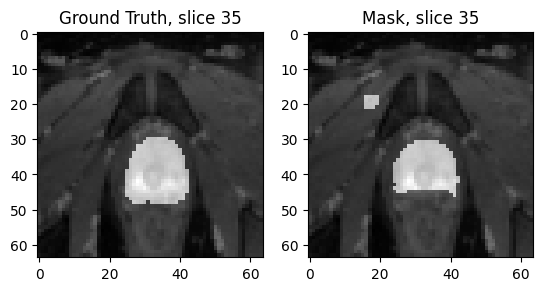

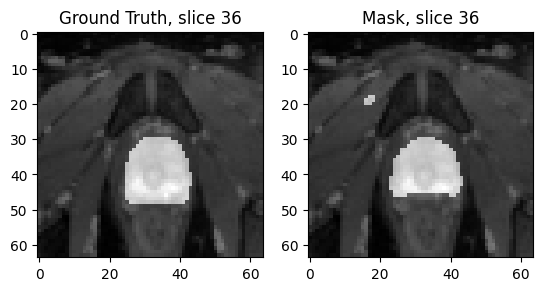

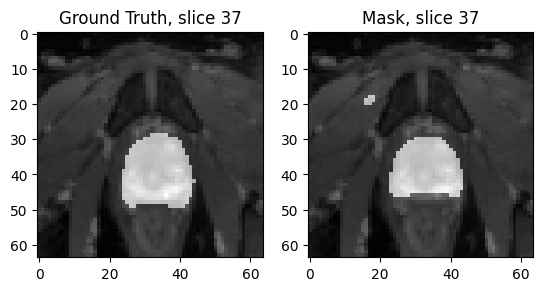

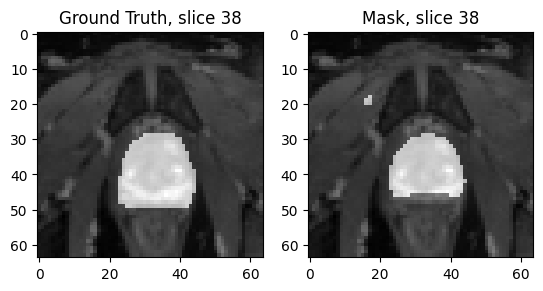

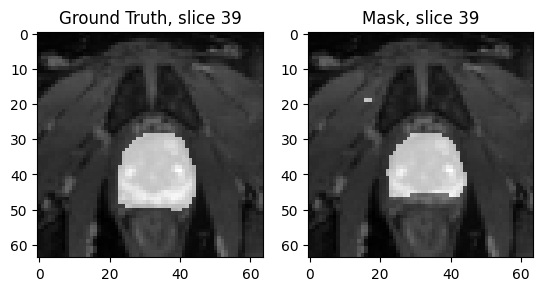

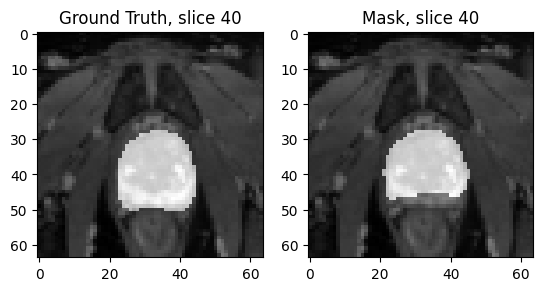

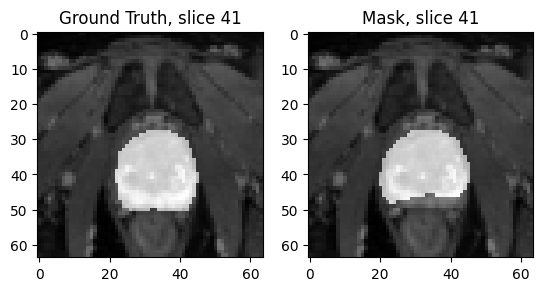

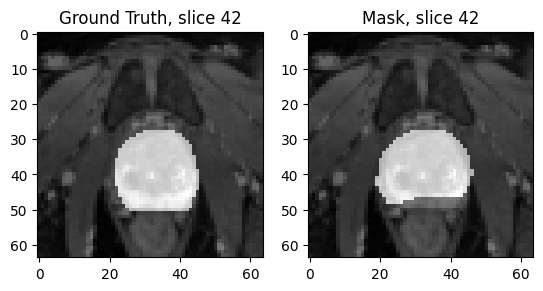

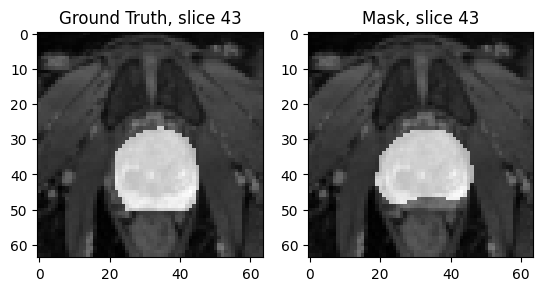

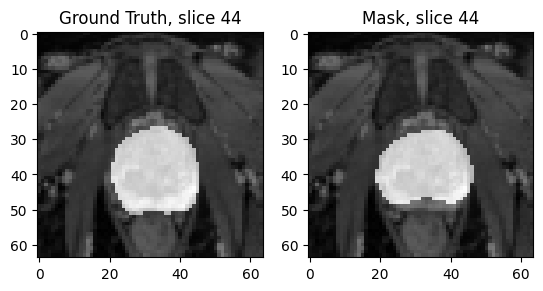

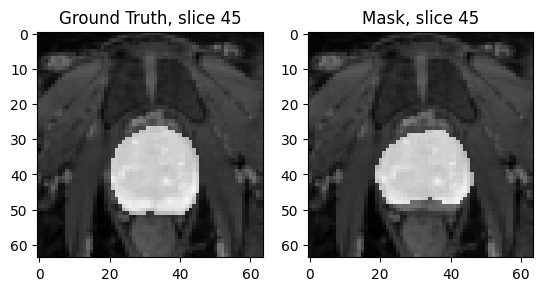

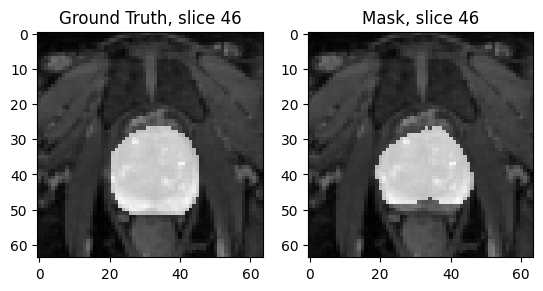

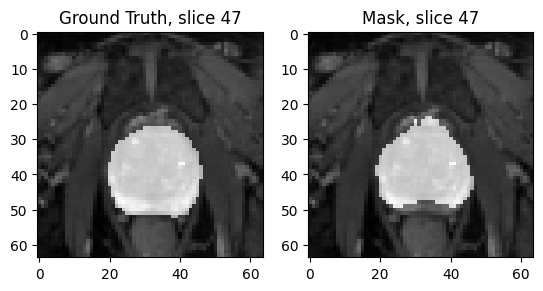

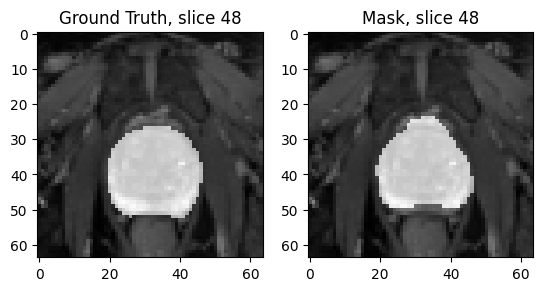

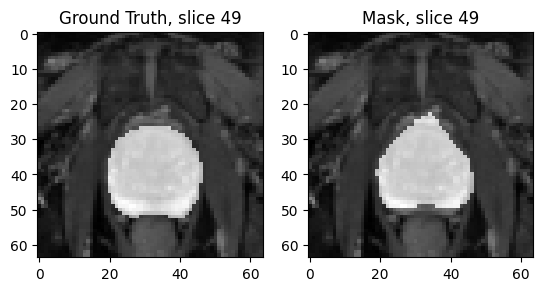

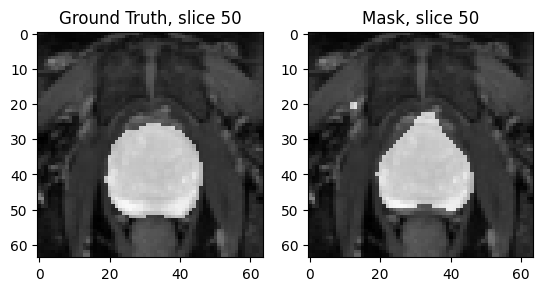

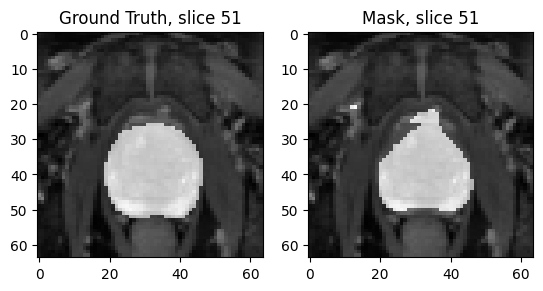

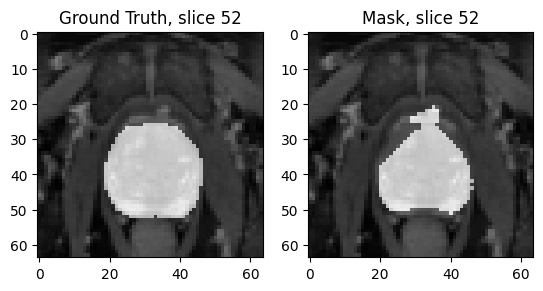

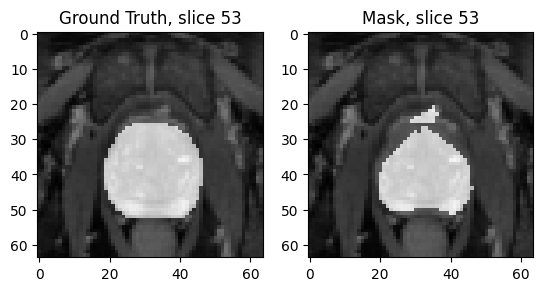

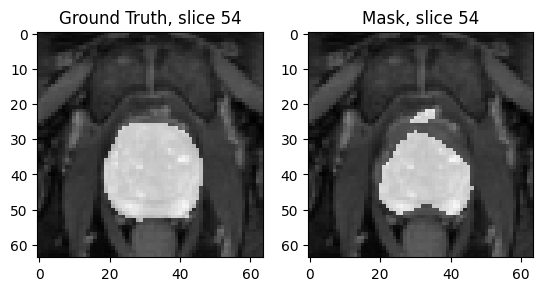

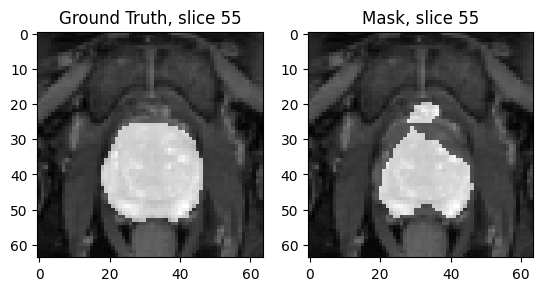

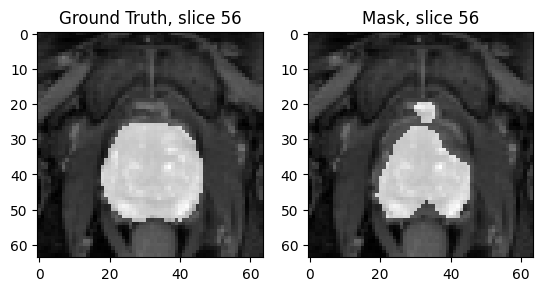

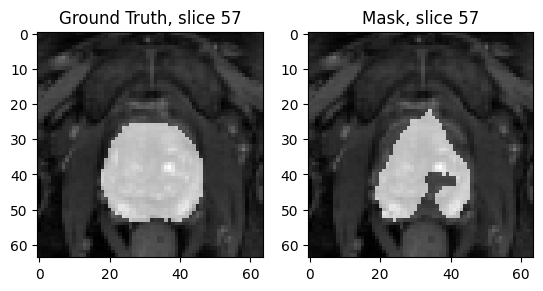

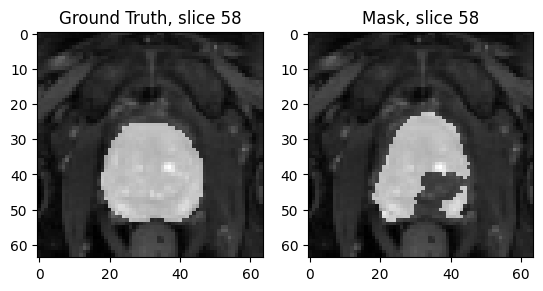

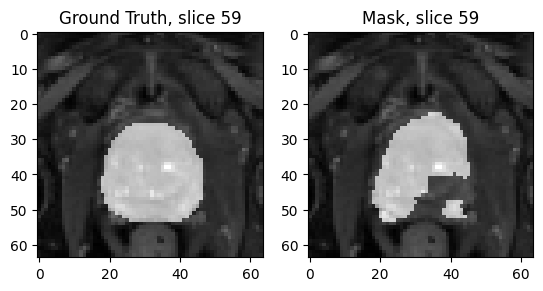

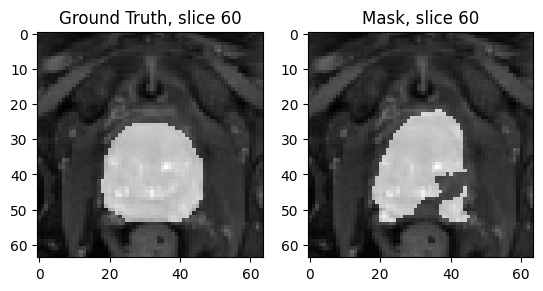

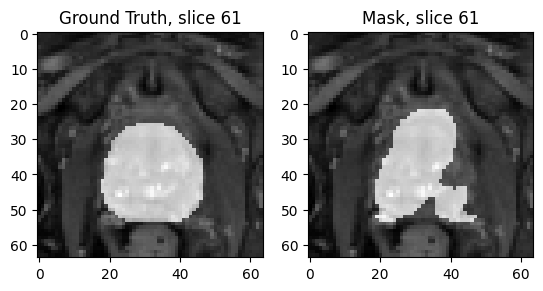

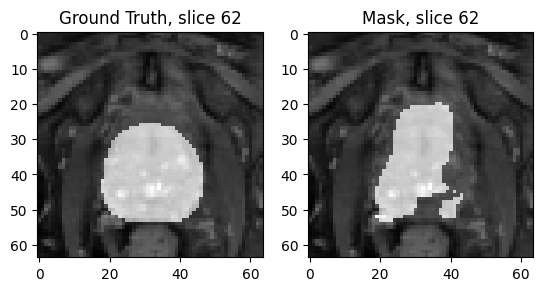

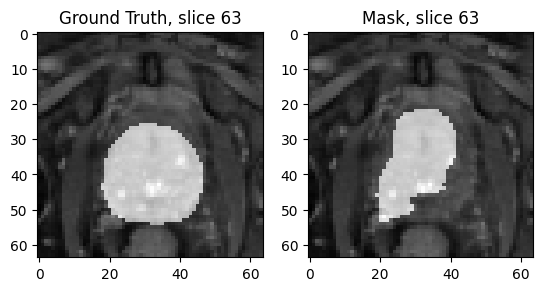

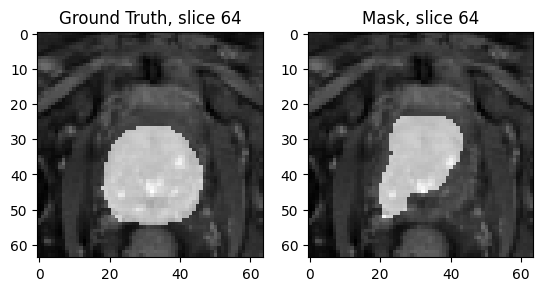

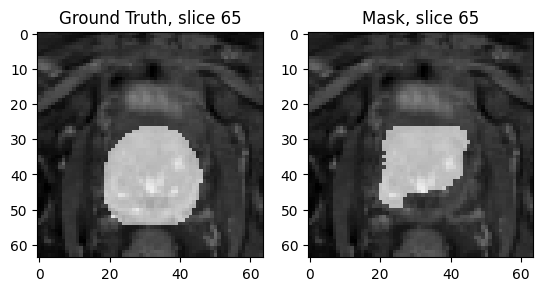

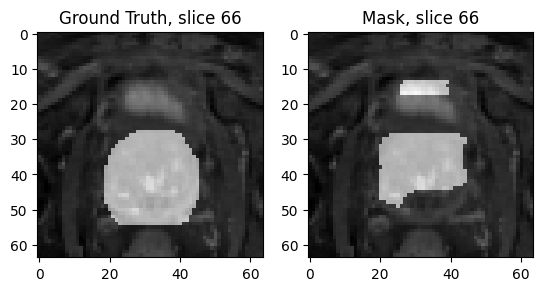

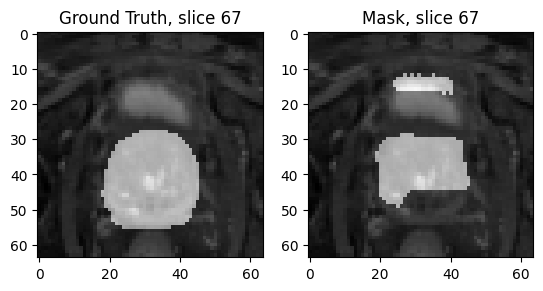

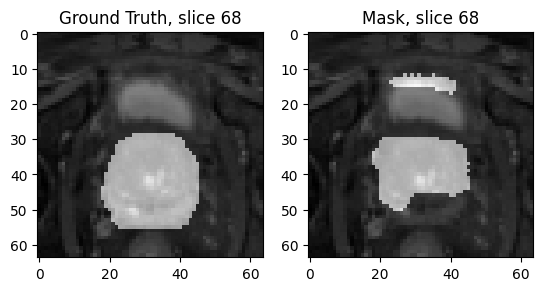

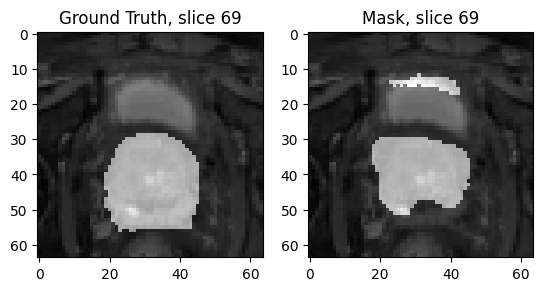

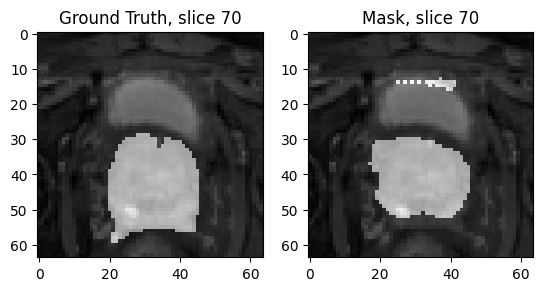

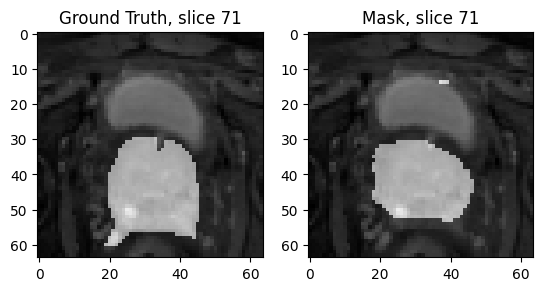

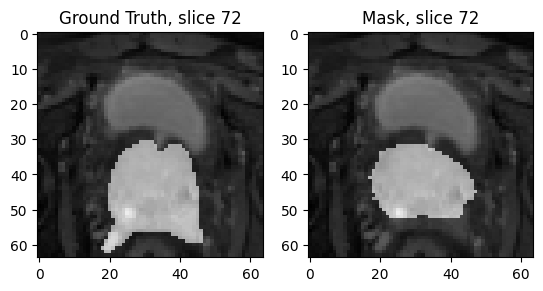

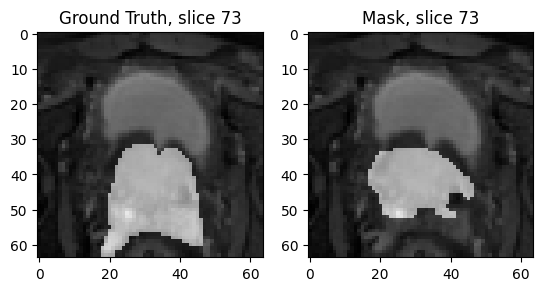

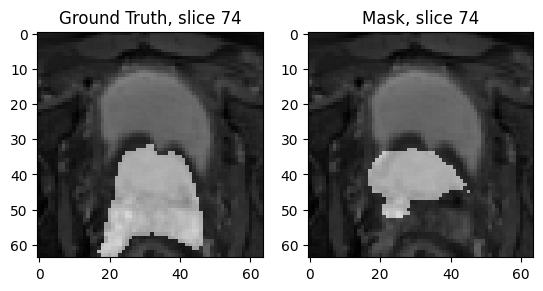

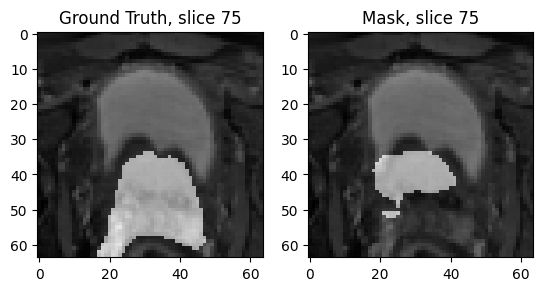

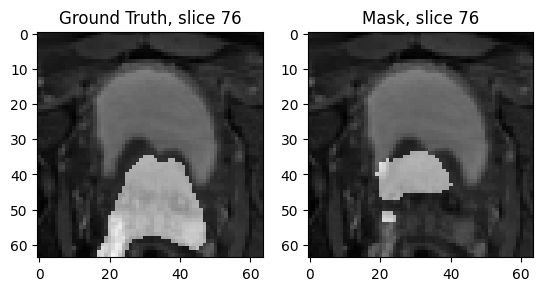

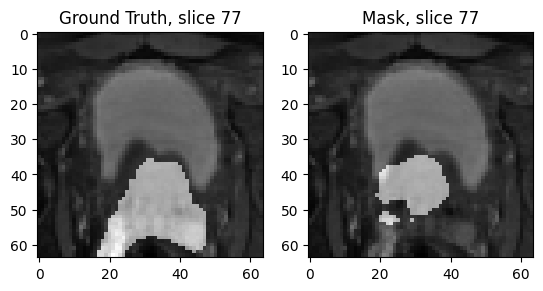

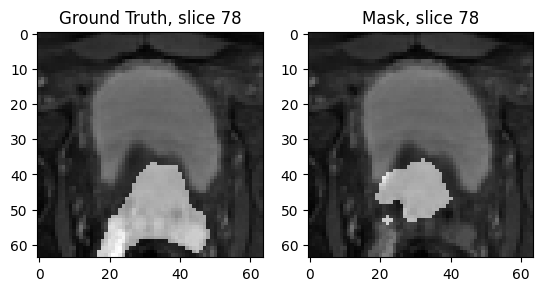

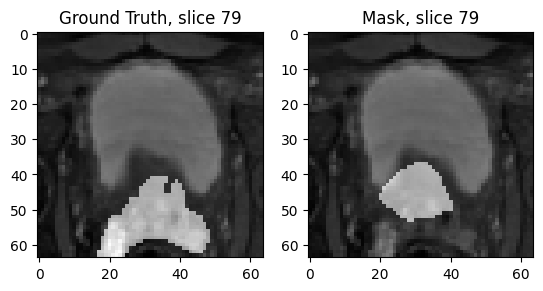

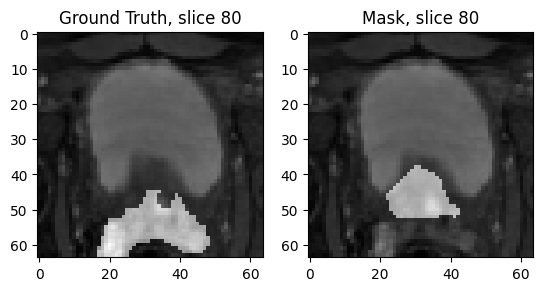

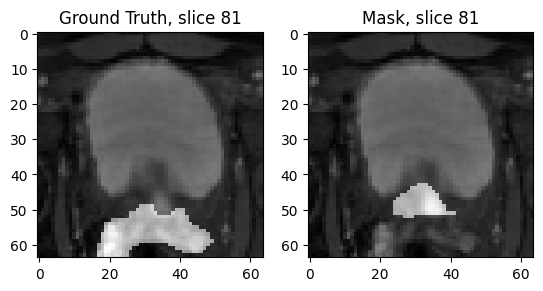

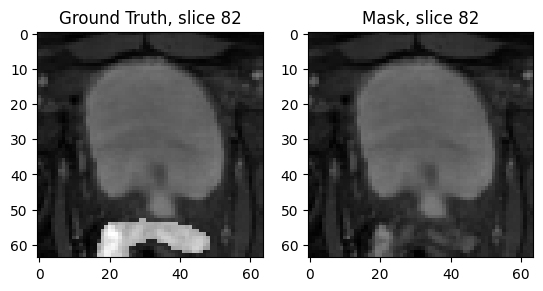

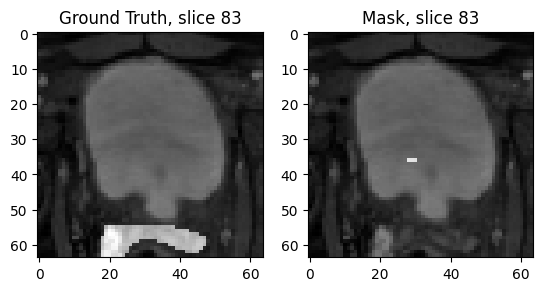

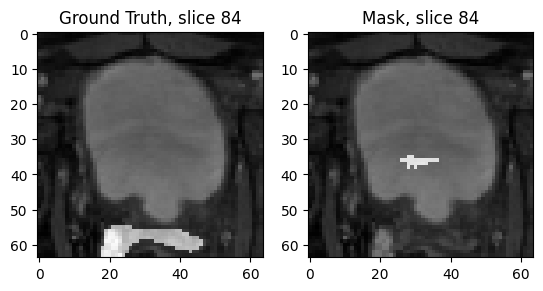

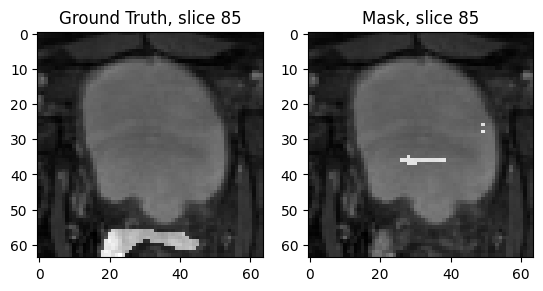

In [81]:
# Use the 2D images that are saved to create 3D
mask_3D = []
ground_truth_3D = []
image_3D = []
for predict_index in range(86):
    read_path_mask = results_folder_2 + '\{}_mask_2D.mhd'.format(predict_index)
    read_mask = sitk.ReadImage(read_path_mask)
    array_mask = sitk.GetArrayFromImage(read_mask)
    mask_3D.append(array_mask)
    
    read_path_ground_truth = results_folder_2 + '\{}_ground_truth_2D.mhd'.format(predict_index)
    read_ground_truth = sitk.ReadImage(read_path_ground_truth)
    array_ground_truth = sitk.GetArrayFromImage(read_ground_truth)
    ground_truth_3D.append(array_ground_truth)
    
    read_path_image = results_folder_2 + '\{}_image_2D.mhd'.format(predict_index)
    read_image = sitk.ReadImage(read_path_image)
    array_image = sitk.GetArrayFromImage(read_image)
    image_3D.append(array_image)

save_path_mask = results_folder_2 + '\mask_3D.mhd'
save_mask_3D = sitk.GetImageFromArray(mask_3D)
sitk.WriteImage(save_mask_3D,save_path_mask)

save_path_ground_truth = results_folder_2 + '\ground_truth_3D.mhd'
save_ground_truth_3D = sitk.GetImageFromArray(ground_truth_3D)
sitk.WriteImage(save_ground_truth_3D,save_path_ground_truth)

save_path_image = results_folder_3 + '\image_3D.mhd'
save_image_3D = sitk.GetImageFromArray(image_3D)
sitk.WriteImage(save_image_3D,save_path_image)

mask_result = sitk.ReadImage(save_path_mask)
mask_array_result = sitk.GetArrayFromImage(mask_result)

ground_truth_result = sitk.ReadImage(save_path_ground_truth)
ground_truth_array_result = sitk.GetArrayFromImage(ground_truth_result)

image_result = sitk.ReadImage(save_path_image)
image_array_result = sitk.GetArrayFromImage(image_result)

# show each slice of the 3D image, 
for i in range(86):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image_array_result[i,:,:], cmap="gray")
    ax[0].imshow(ground_truth_array_result[i,:,:], cmap="gray", alpha=0.5)
    ax[0].set_title("Ground Truth, slice {}".format(i))
    ax[1].imshow(image_array_result[i,:,:], cmap="gray")
    ax[1].imshow(mask_array_result[i,:,:], cmap="gray", alpha=0.5)
    ax[1].set_title("Mask, slice {}".format(i))

    plt.show()

In [58]:
# Calculate the Dice score and HD
p2_dice_coeffs=[]
p2_hausdorff_95=[]
p2_both_black=0
p2_one_black = 0

for slice_id in range(86):
    mask_path = results_folder_2+ '\{}_mask_2D.mhd'.format(slice_id)
    ground_truth_path = results_folder_2+ '\{}_ground_truth_2D.mhd'.format(slice_id)
        
    dice_coeff= diceFunction(ground_truth_path, mask_path)
    p2_dice_coeffs.append(dice_coeff)
        
    #get extrema ground truth
    readable_ground_truth = imageio.imread(ground_truth_path)
    gt_result = Image.fromarray(readable_ground_truth)
    extrema_result = gt_result.getextrema()
        
    #get extrema predicted mask
    readable_mask = imageio.imread(mask_path)
    mask_result = Image.fromarray(readable_mask)
    extrema_orig = mask_result.getextrema()
             
    # do not calculate Hausdorff distance if segmentation is black
    if extrema_result[1]== 0 and extrema_orig[1]==0:
        p2_both_black += 1

    else:
        if extrema_result[1] == 0 and extrema_orig[1] != 0:
            p2_one_black += 1
        if extrema_result[1] != 0 and extrema_orig[1] == 0:
            p2_one_black += 1
                
    if extrema_result[0] != extrema_result[1] and extrema_orig[1] != 0:
        quality= computeQualityMeasures(ground_truth_path, mask_path)
        p2_hausdorff_95.append(quality.get('hausdorff_95'))

print("These are the results for patient 2")
print(p2_both_black, "both black")
print(p2_one_black, "one black")

p2_avg_dice= np.mean(p2_dice_coeffs)
p2_avg_hausdorff_95=np.mean(p2_hausdorff_95)
print(p2_dice_coeffs, "Dice")
print(p2_avg_dice, "Average dice")
print(p2_hausdorff_95, "HD 95")
print(p2_avg_hausdorff_95, "Average HD 95")

These are the results for patient 2
0 both black
27 one black
[0.02040816326530612, 0.018518518518518517, 0.017543859649122806, 0.021739130434782608, 0.03333333333333333, 0.030303030303030304, 0.030303030303030304, 0.02702702702702703, 0.02127659574468085, 0.015151515151515152, 0.0125, 0.010526315789473684, 0.007936507936507936, 0.0053475935828877, 0.0038022813688212928, 0.003215434083601286, 0.002898550724637681, 0.0029154518950437317, 0.0029411764705882353, 0.002932551319648094, 0.0027624309392265192, 0.0028653295128939827, 0.003215434083601286, 0.003125, 0.0032258064516129032, 0.0033222591362126247, 0.2936046511627907, 0.4472934472934473, 0.5625, 0.6437908496732027, 0.7287066246056783, 0.7994269340974212, 0.782258064516129, 0.7425, 0.765625, 0.8123827392120075, 0.8659966499162479, 0.8648233486943164, 0.8557284299858557, 0.8738255033557047, 0.8654320987654321, 0.8727064220183486, 0.8724324324324324, 0.8789473684210526, 0.8948979591836734, 0.8916750250752257, 0.8929273084479371, 0.899

### Patient 3

In [72]:
# U-Net with patient 3
# set model to evaluation mode
unet_model.eval()

results_folder_3 = r'C:\Users\Luuk\Desktop\Results\Patient_3'

with torch.no_grad():
    for predict_index in range(86):
        (input, target) = dataset_p3[predict_index]
        output = torch.sigmoid(unet_model(input[np.newaxis, ...]))
        prediction = torch.round(output)
        
        # each image, ground truth and mask should be saved in 2D
        predicted_mask = sitk.GetImageFromArray(prediction[0, 0])
        path_mask = results_folder_3 + '\{}_mask_2D.mhd'.format(predict_index)
        sitk.WriteImage(predicted_mask, path_mask)
        ground_truth = sitk.GetImageFromArray(target[0])
        path_ground_truth = results_folder_3 + '\{}_ground_truth_2D.mhd'.format(predict_index)
        sitk.WriteImage(ground_truth, path_ground_truth)
        MR_image = sitk.GetImageFromArray(input[0])
        path_image = results_folder_3 + '\{}_image_2D.mhd'.format(predict_index)
        sitk.WriteImage(MR_image, path_image)
        
        # display the images, will also be done in the next cell, so commented here
#         fig, ax = plt.subplots(1, 3)
#         ax[0].imshow(input[0], cmap="gray")
#         ax[0].set_title("Input")
#         ax[0].axis("off")

#         ax[1].imshow(target[0], cmap="gray")
#         ax[1].set_title("Ground-truth")
#         ax[1].axis("off")

#         ax[2].imshow(prediction[0, 0], cmap="gray")
#         ax[2].set_title("Prediction")
#         ax[2].axis("off")
#         plt.show()

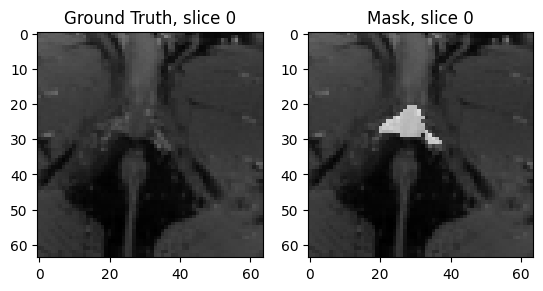

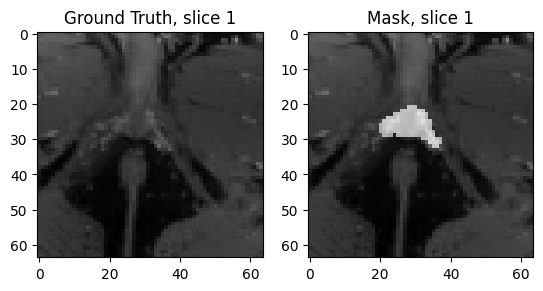

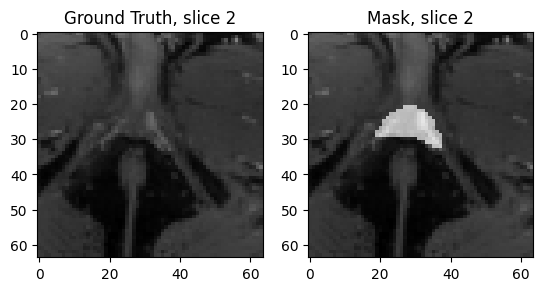

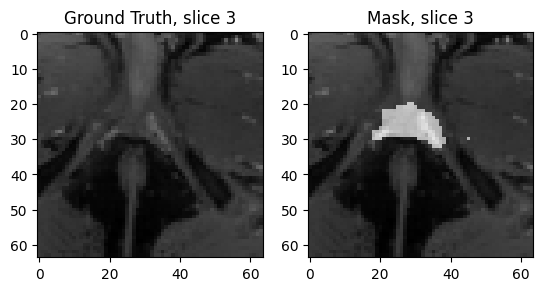

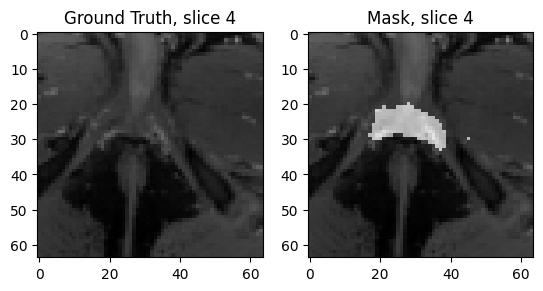

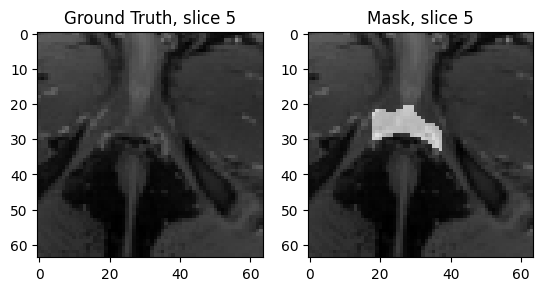

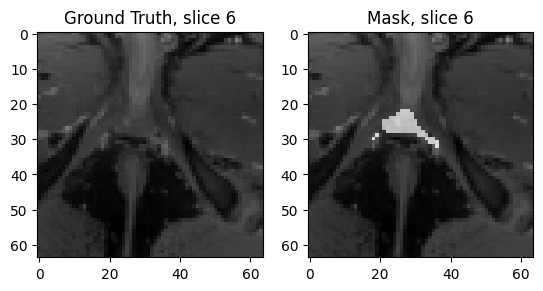

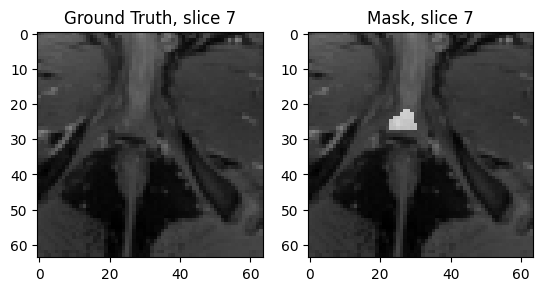

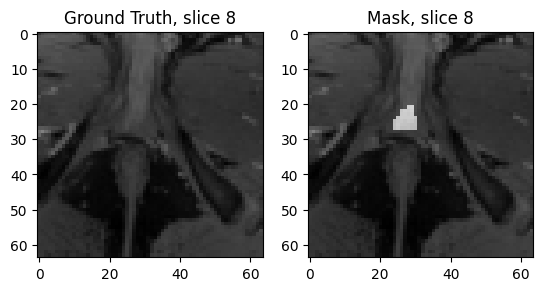

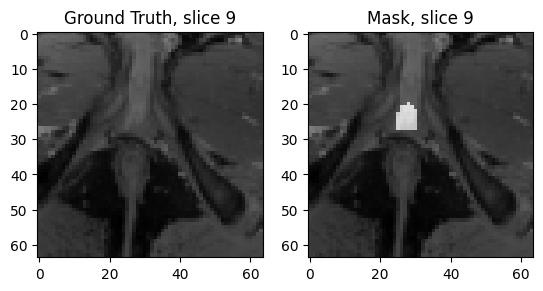

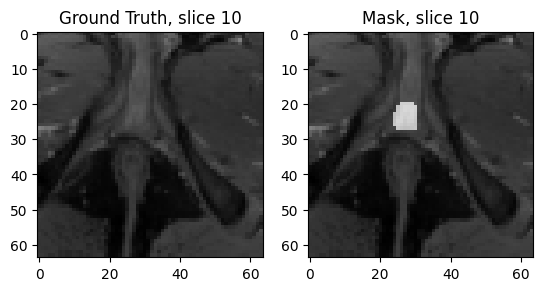

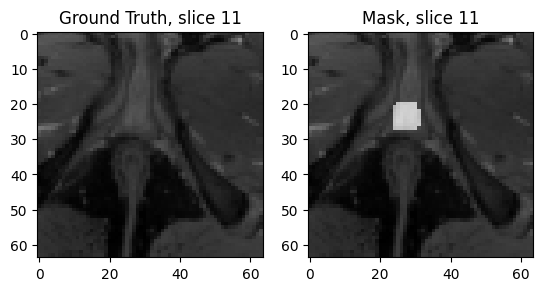

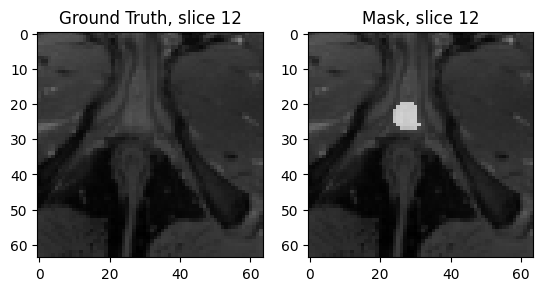

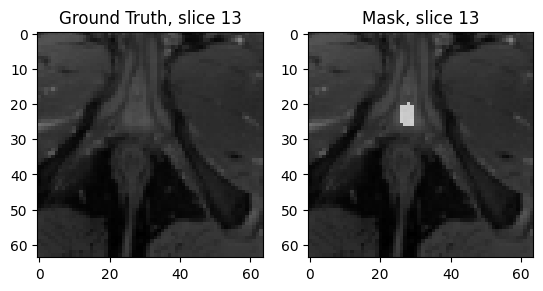

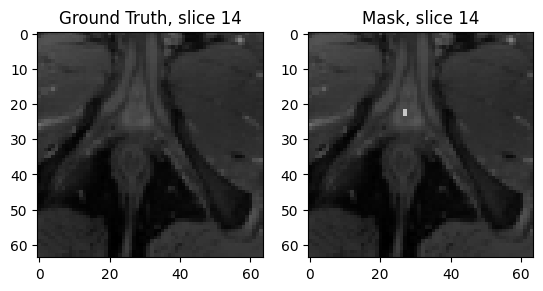

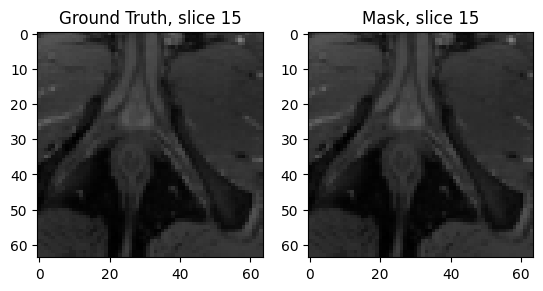

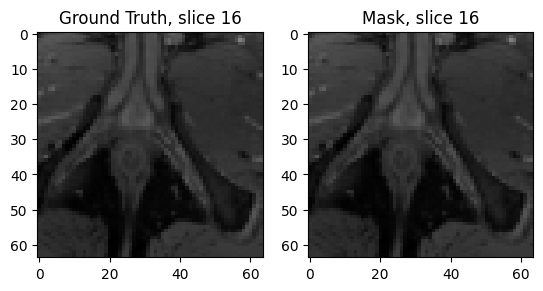

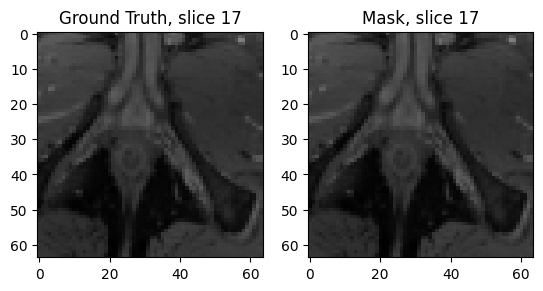

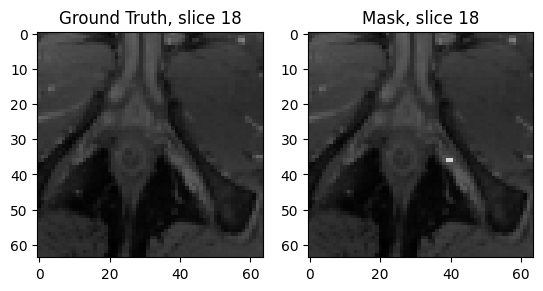

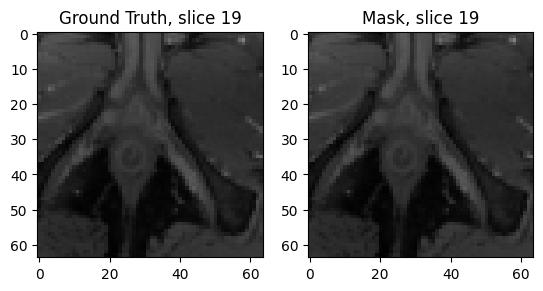

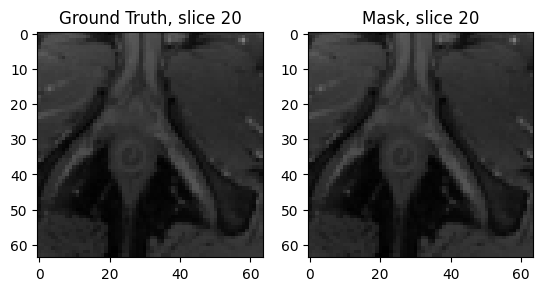

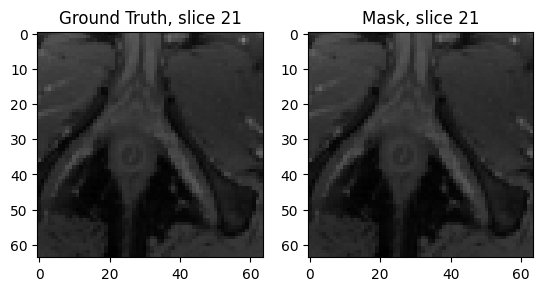

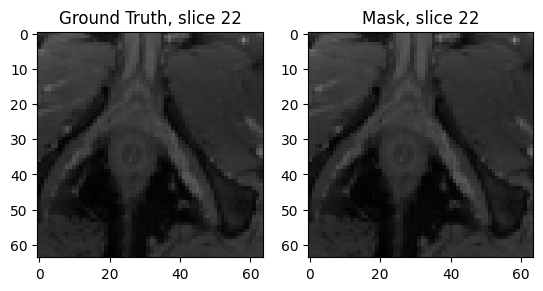

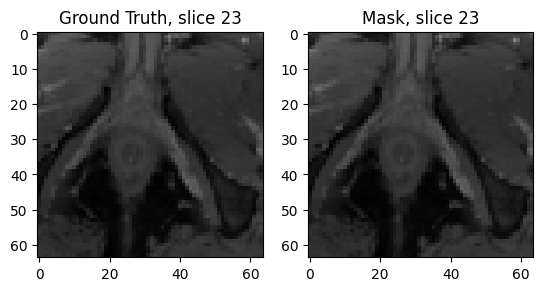

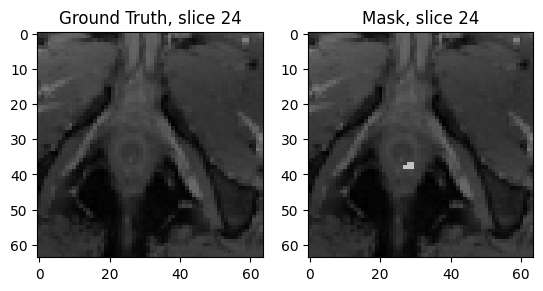

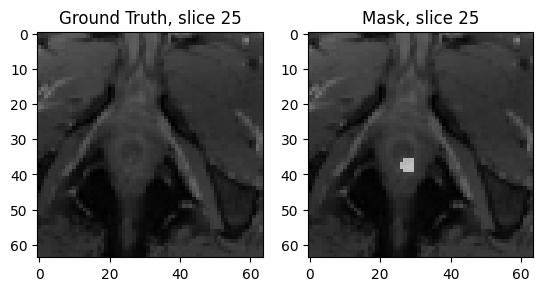

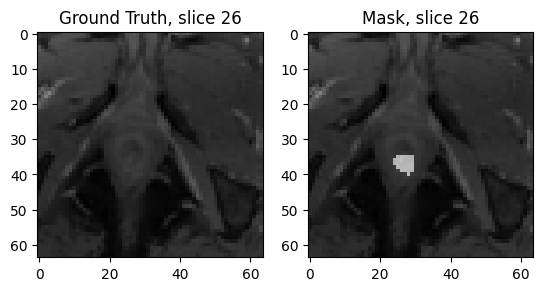

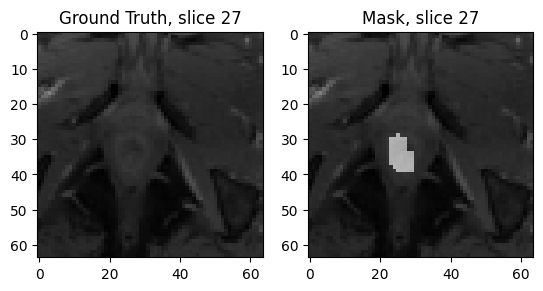

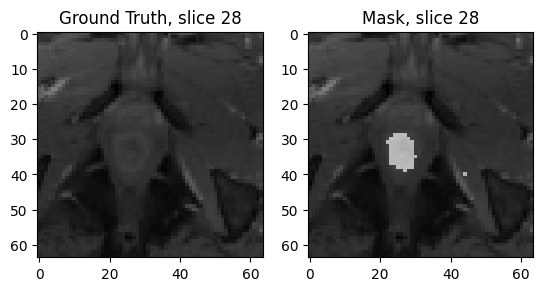

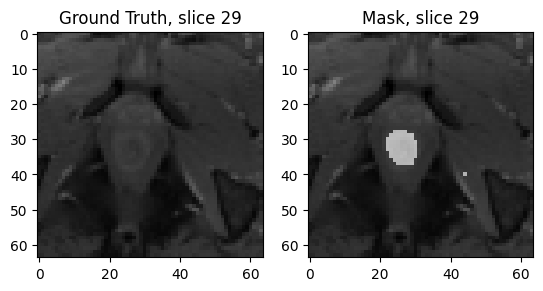

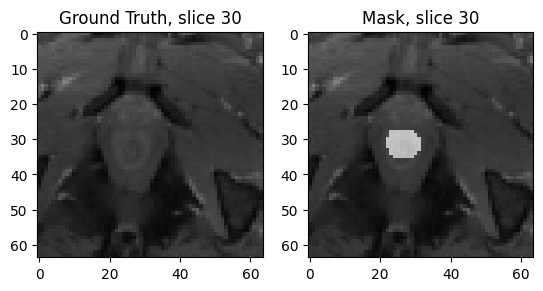

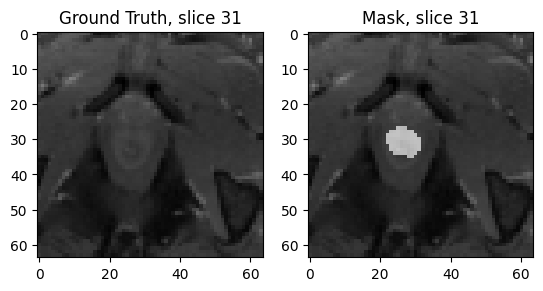

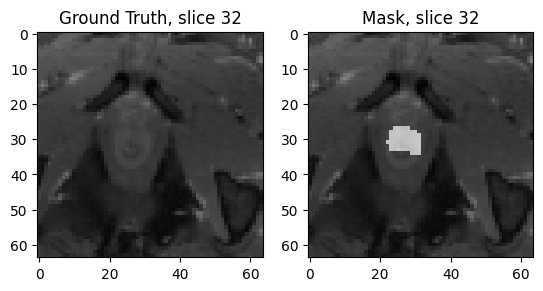

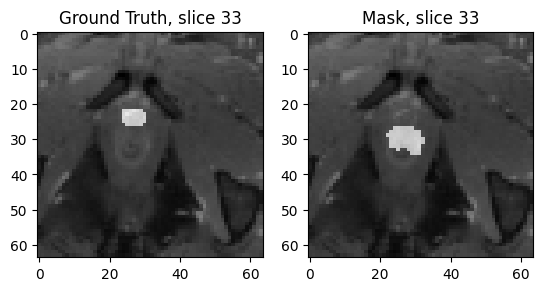

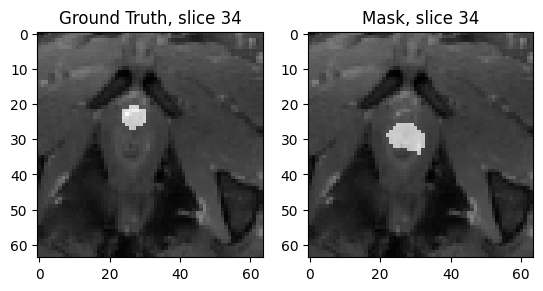

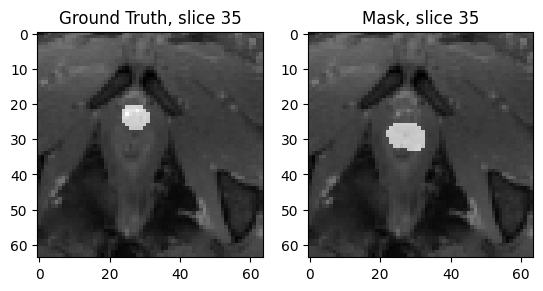

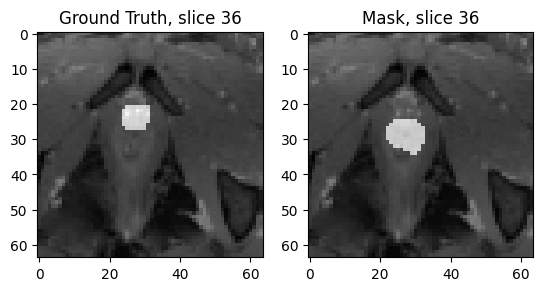

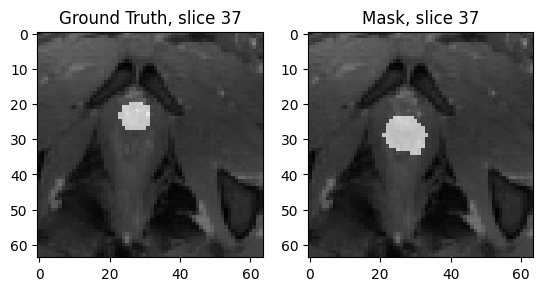

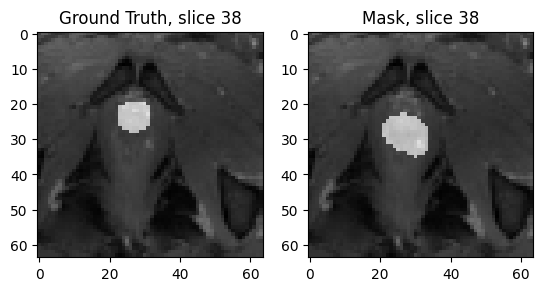

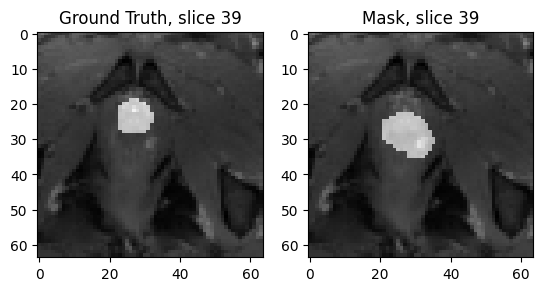

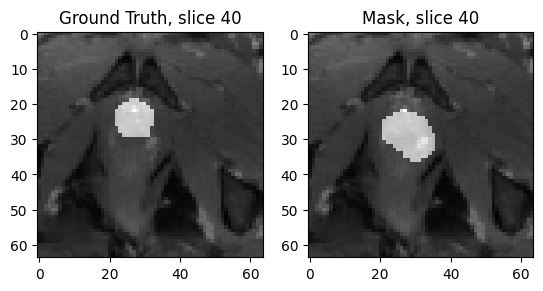

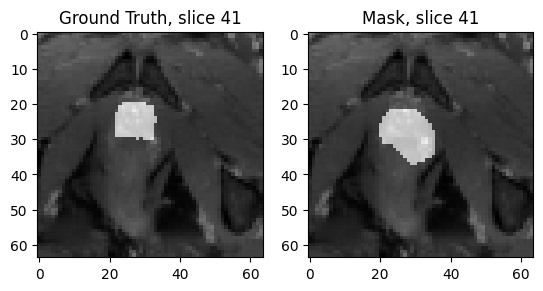

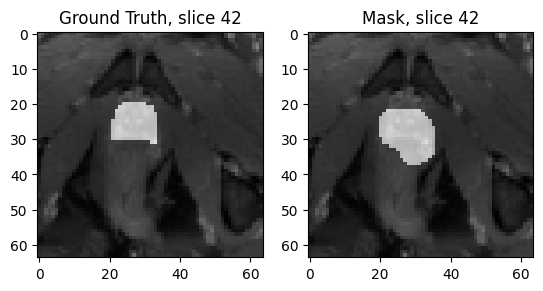

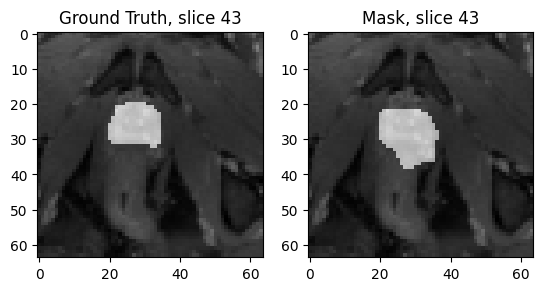

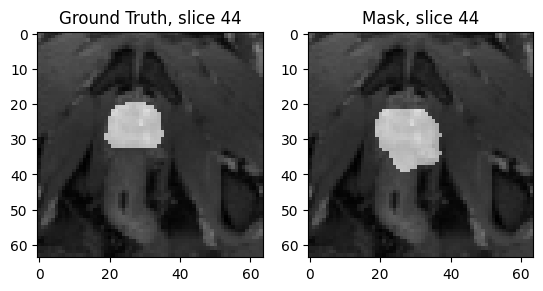

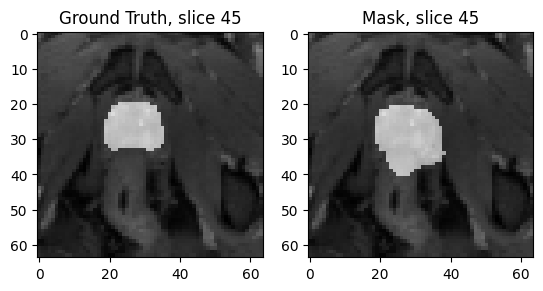

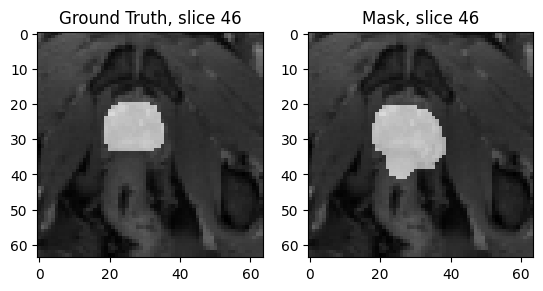

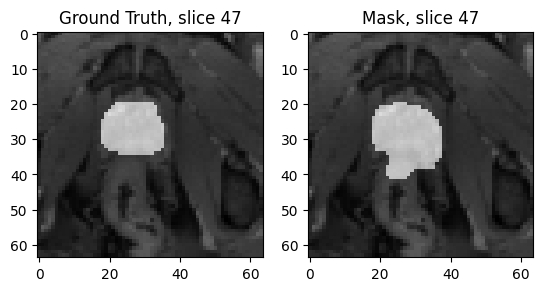

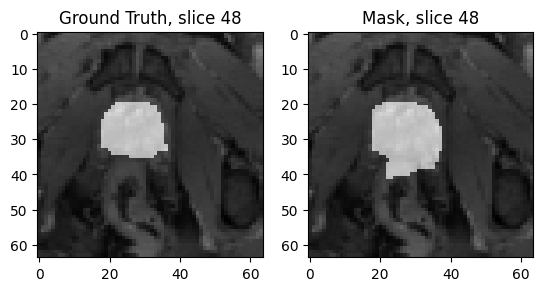

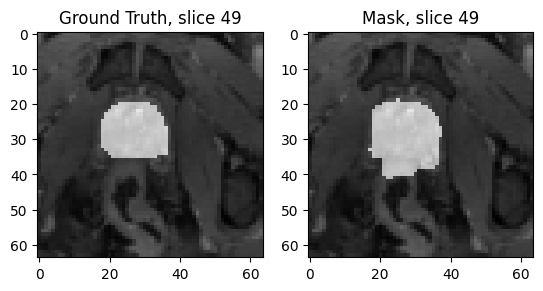

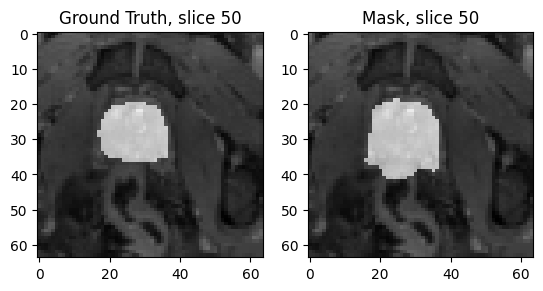

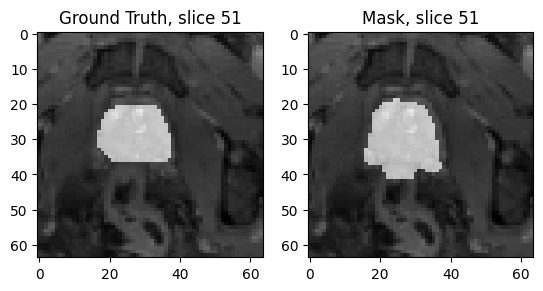

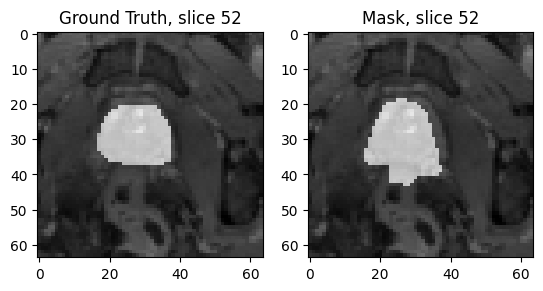

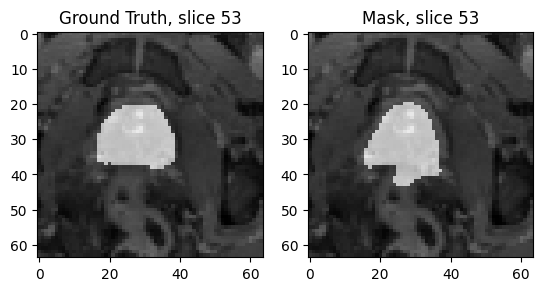

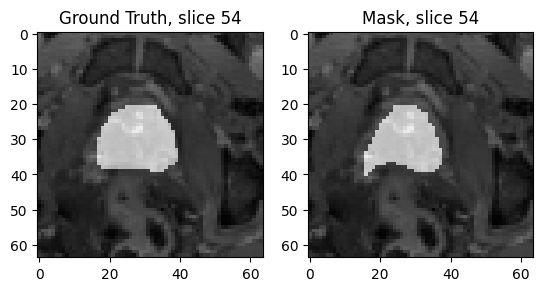

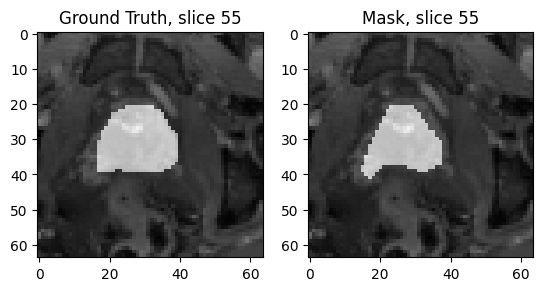

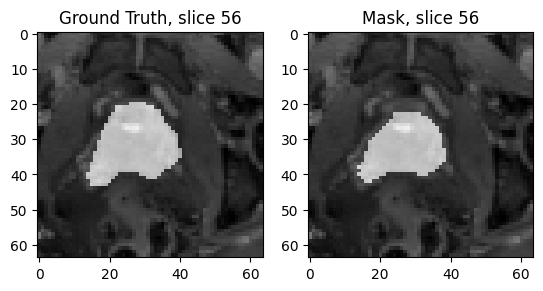

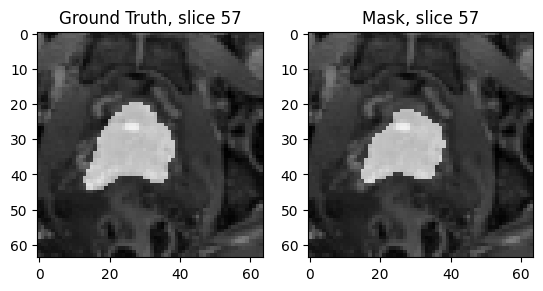

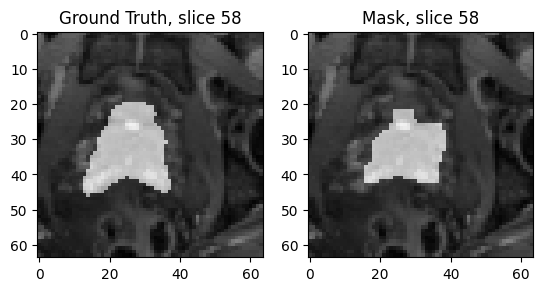

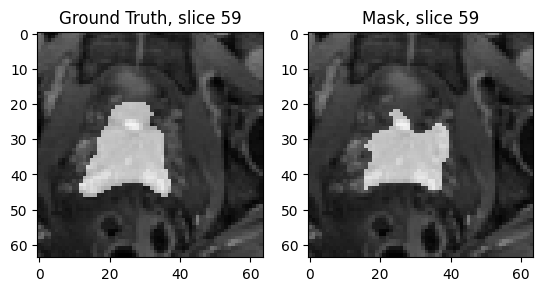

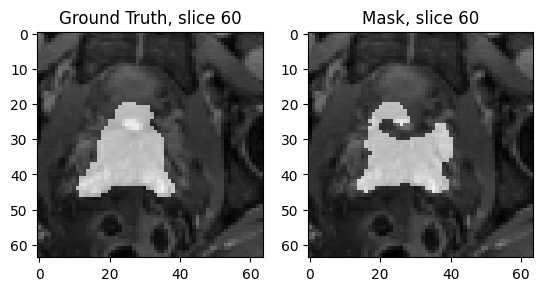

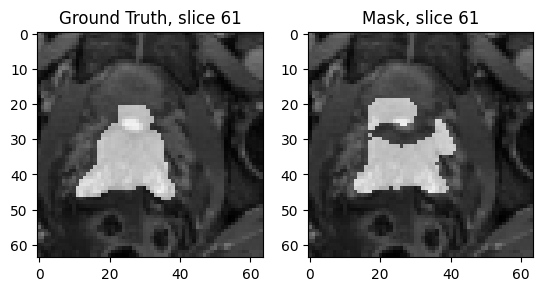

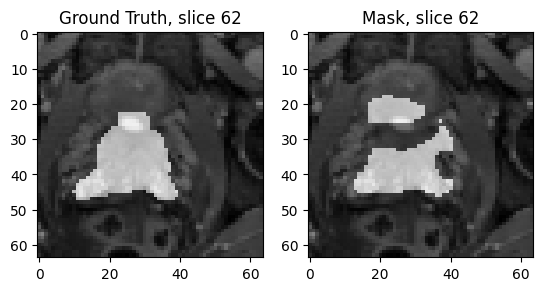

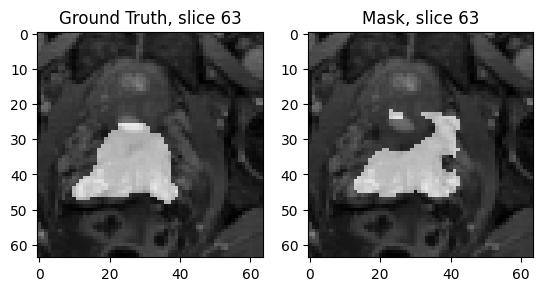

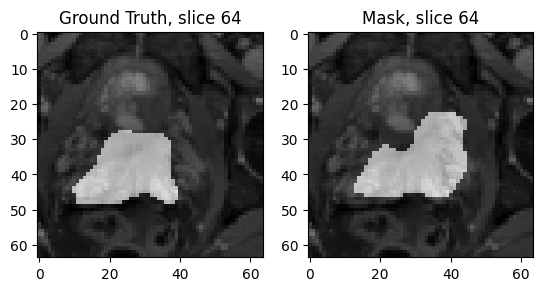

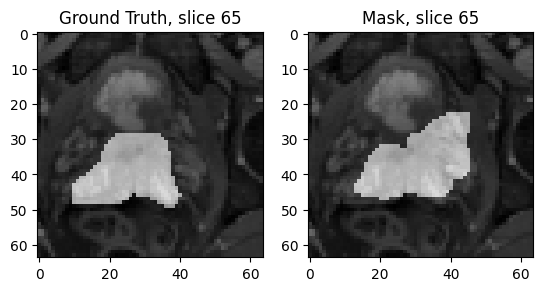

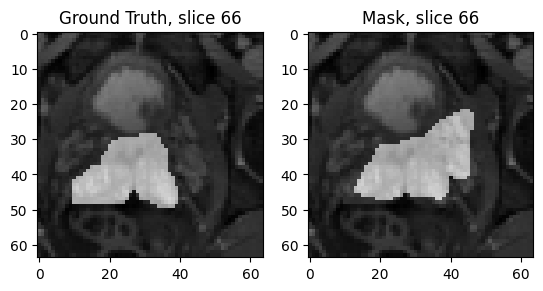

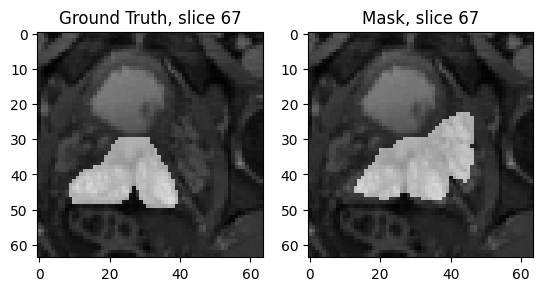

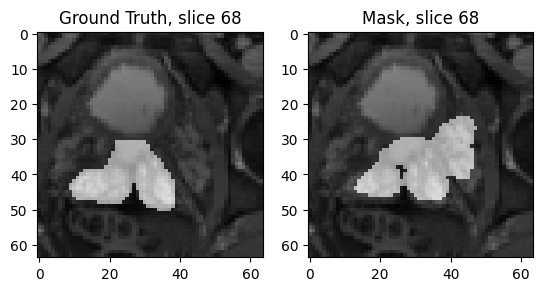

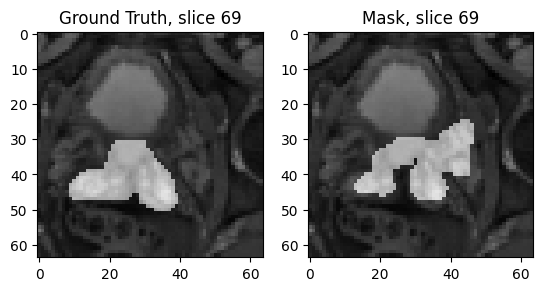

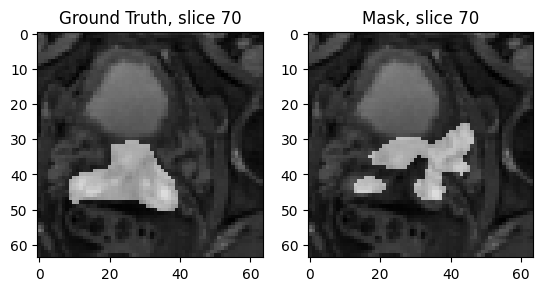

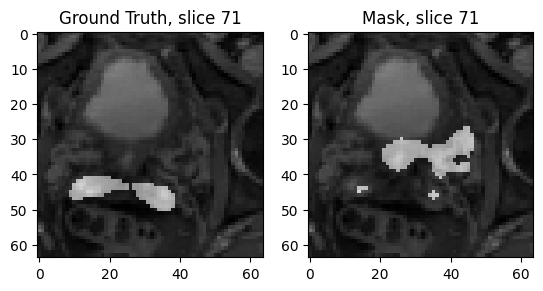

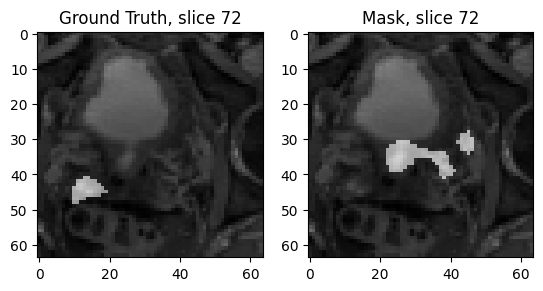

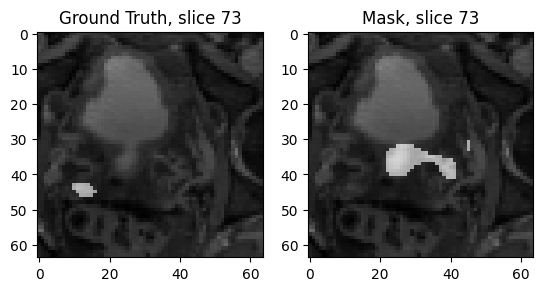

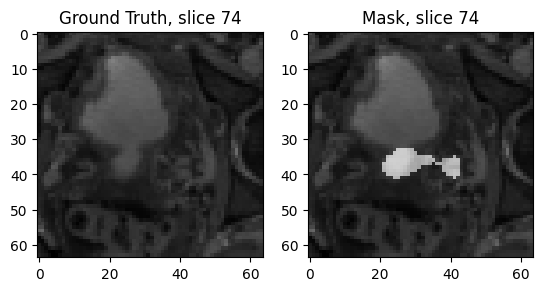

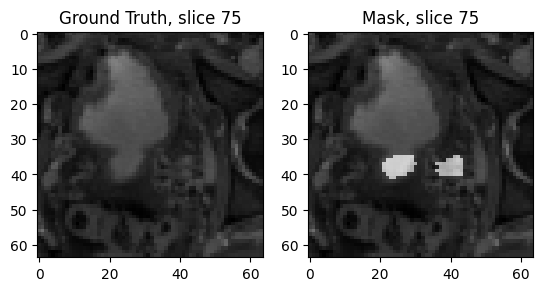

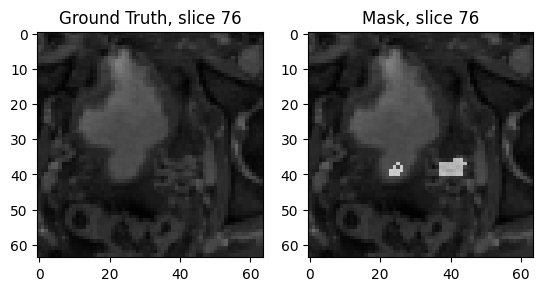

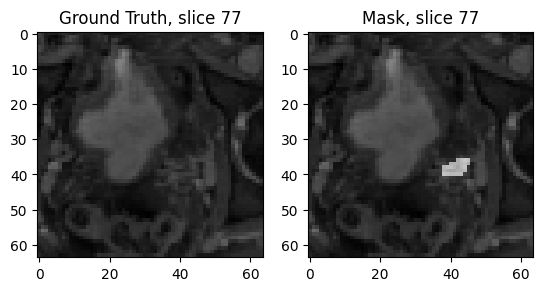

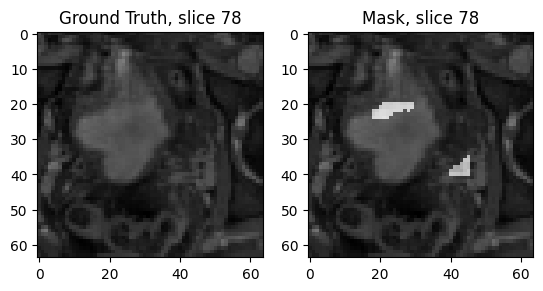

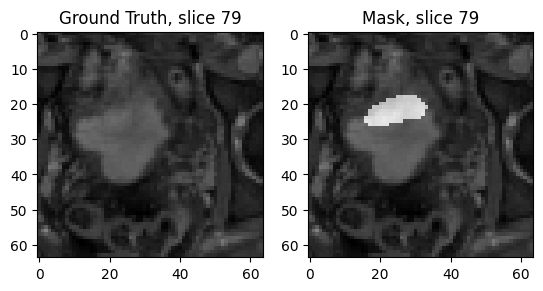

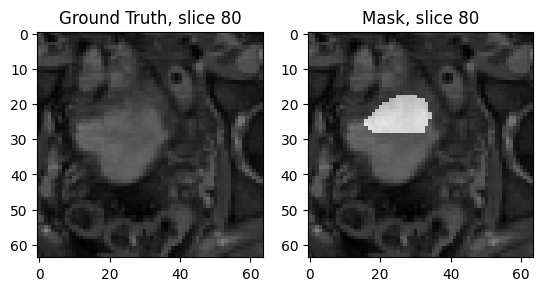

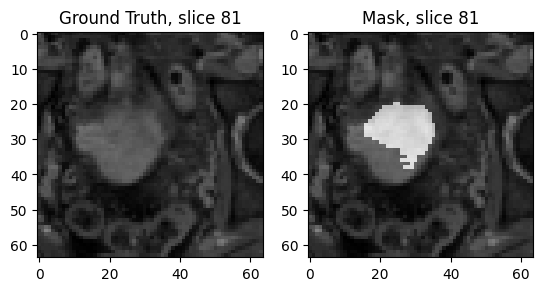

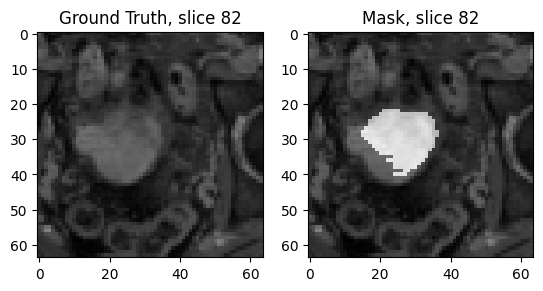

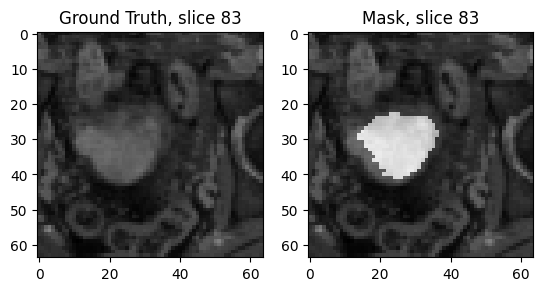

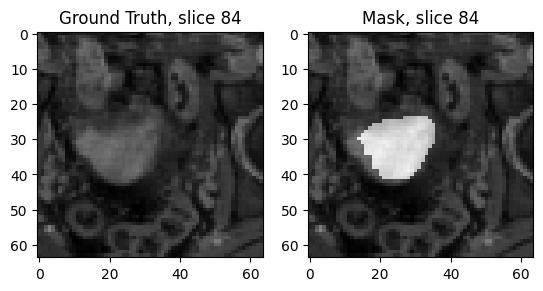

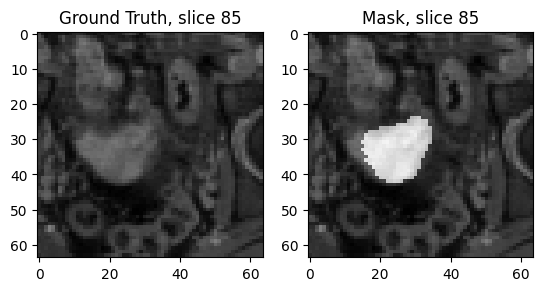

In [75]:
# Use the 2D images that are saved to create 3D
mask_3D = []
ground_truth_3D = []
image_3D = []
for predict_index in range(86):
    read_path_mask = results_folder_3 + '\{}_mask_2D.mhd'.format(predict_index)
    read_mask = sitk.ReadImage(read_path_mask)
    array_mask = sitk.GetArrayFromImage(read_mask)
    mask_3D.append(array_mask)
    
    read_path_ground_truth = results_folder_3 + '\{}_ground_truth_2D.mhd'.format(predict_index)
    read_ground_truth = sitk.ReadImage(read_path_ground_truth)
    array_ground_truth = sitk.GetArrayFromImage(read_ground_truth)
    ground_truth_3D.append(array_ground_truth)
    
    read_path_image = results_folder_3 + '\{}_image_2D.mhd'.format(predict_index)
    read_image = sitk.ReadImage(read_path_image)
    array_image = sitk.GetArrayFromImage(read_image)
    image_3D.append(array_image)

save_path_mask = results_folder_3 + '\mask_3D.mhd'
save_mask_3D = sitk.GetImageFromArray(mask_3D)
sitk.WriteImage(save_mask_3D,save_path_mask)

save_path_ground_truth = results_folder_3 + '\ground_truth_3D.mhd'
save_ground_truth_3D = sitk.GetImageFromArray(ground_truth_3D)
sitk.WriteImage(save_ground_truth_3D,save_path_ground_truth)

save_path_image = results_folder_3 + '\image_3D.mhd'
save_image_3D = sitk.GetImageFromArray(image_3D)
sitk.WriteImage(save_image_3D,save_path_image)

mask_result = sitk.ReadImage(save_path_mask)
mask_array_result = sitk.GetArrayFromImage(mask_result)

ground_truth_result = sitk.ReadImage(save_path_ground_truth)
ground_truth_array_result = sitk.GetArrayFromImage(ground_truth_result)

image_result = sitk.ReadImage(save_path_image)
image_array_result = sitk.GetArrayFromImage(image_result)

# show each slice of the 3D image, 
for i in range(86):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image_array_result[i,:,:], cmap="gray")
    ax[0].imshow(ground_truth_array_result[i,:,:], cmap="gray", alpha=0.5)
    ax[0].set_title("Ground Truth, slice {}".format(i))
    ax[1].imshow(image_array_result[i,:,:], cmap="gray")
    ax[1].imshow(mask_array_result[i,:,:], cmap="gray", alpha=0.5)
    ax[1].set_title("Mask, slice {}".format(i))

    plt.show()

In [62]:
# Calculate the Dice score and HD
p3_dice_coeffs=[]
p3_hausdorff_95=[]
p3_both_black=0
p3_one_black = 0

for slice_id in range(86):
    mask_path = results_folder_3+ '\{}_mask_2D.mhd'.format(slice_id)
    ground_truth_path = results_folder_3+ '\{}_ground_truth_2D.mhd'.format(slice_id)
        
    dice_coeff= diceFunction(ground_truth_path, mask_path)
    p3_dice_coeffs.append(dice_coeff)
        
    #get extrema ground truth
    readable_ground_truth = imageio.imread(ground_truth_path)
    gt_result = Image.fromarray(readable_ground_truth)
    extrema_result = gt_result.getextrema()
        
    #get extrema predicted mask
    readable_mask = imageio.imread(mask_path)
    mask_result = Image.fromarray(readable_mask)
    extrema_orig = mask_result.getextrema()
             
    # do not calculate Hausdorff distance if segmentation is black
    if extrema_result[1]== 0 and extrema_orig[1]==0:
        p3_both_black += 1

    else:
        if extrema_result[1] == 0 and extrema_orig[1] != 0:
            p3_one_black += 1
        if extrema_result[1] != 0 and extrema_orig[1] == 0:
            p3_one_black += 1
                
    if extrema_result[0] != extrema_result[1] and extrema_orig[1] != 0:
        quality= computeQualityMeasures(ground_truth_path, mask_path)
        p3_hausdorff_95.append(quality.get('hausdorff_95'))

print("These are the results for patient 1")
print(p3_both_black, "both black")
print(p3_one_black, "one black")

p3_avg_dice= np.mean(p3_dice_coeffs)
p3_avg_hausdorff_95=np.mean(p3_hausdorff_95)
print(p3_dice_coeffs, "Dice")
print(p3_avg_dice, "Average dice")
print(p3_hausdorff_95, "HD 95")
print(p3_avg_hausdorff_95, "Average HD 95")

These are the results for patient 1
8 both black
37 one black
[0.011235955056179775, 0.008403361344537815, 0.007407407407407408, 0.00625, 0.005813953488372093, 0.006993006993006993, 0.014285714285714285, 0.027777777777777776, 0.02631578947368421, 0.024390243902439025, 0.0196078431372549, 0.01639344262295082, 0.0196078431372549, 0.04, 0.3333333333333333, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 0.16666666666666666, 0.06666666666666667, 0.03571428571428571, 0.01639344262295082, 0.014492753623188406, 0.013333333333333334, 0.014492753623188406, 0.014925373134328358, 0.015873015873015872, 0.010526315789473684, 0.14285714285714285, 0.17796610169491525, 0.2971014492753623, 0.3395061728395062, 0.4031413612565445, 0.44, 0.5269230769230769, 0.608843537414966, 0.6858006042296072, 0.7408376963350786, 0.7291196388261851, 0.7415506958250497, 0.7421731123388582, 0.7982456140350878, 0.8330550918196995, 0.8492063492063492, 0.8509036144578314, 0.8248502994011976, 0.8121301775147929, 0

### Create the results for in the report

In [71]:
# Combine the Dice and HD for the 3 test patients, the average dice and HD need to be in report

total_dice = np.concatenate((p1_dice_coeffs, p2_dice_coeffs, p3_dice_coeffs), axis=None)
total_avg_dice = np.mean(total_dice)
total_hausdorff_95 = np.concatenate((p1_hausdorff_95, p2_hausdorff_95, p3_hausdorff_95), axis=None)
total_avg_hausdorff_95 = np.mean(total_hausdorff_95)

total_both_black = p1_both_black+p2_both_black+p3_both_black
total_one_black = p1_one_black+p2_one_black+p3_one_black

# values
print("Total Average Dice:", total_avg_dice)
print("Total Average Hausdorff 95:", total_avg_hausdorff_95)
print("Total both black:", total_both_black)
print("Total one black:", total_one_black)

print(len(total_dice)) # 3*86=258
print(len(total_hausdorff_95)) # 156 so <258, but it cannot be calculated when one is black


Total Average Dice: 0.4185172055753224
Total Average Hausdorff 95: 8.805242846829769
Total both black: 12
Total one black: 90
258
156


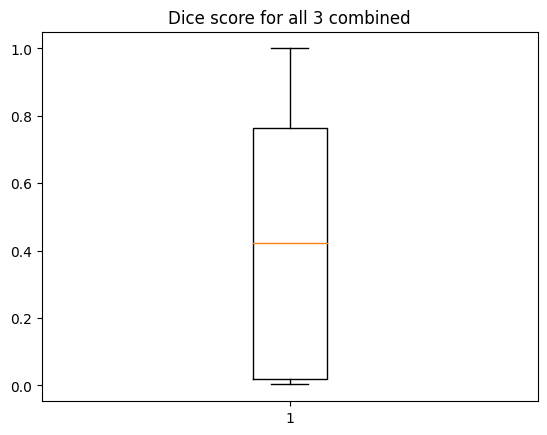

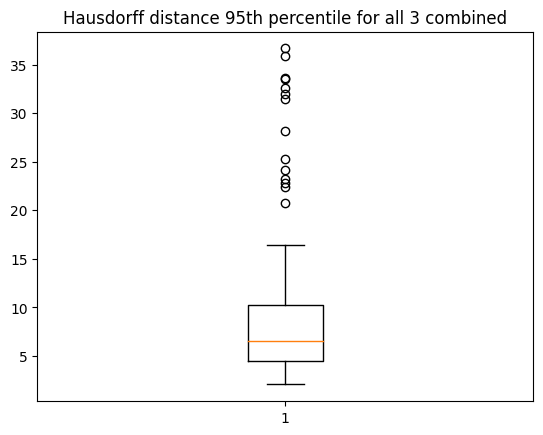

In [70]:
# boxplot of dice and hausdorff for all 3 combined
plt.figure()
plt.boxplot(total_dice)
plt.title("Dice score for all 3 combined")
plt.show()

plt.figure()
plt.boxplot(total_hausdorff_95)
plt.title("Hausdorff distance 95th percentile for all 3 combined")
plt.show()

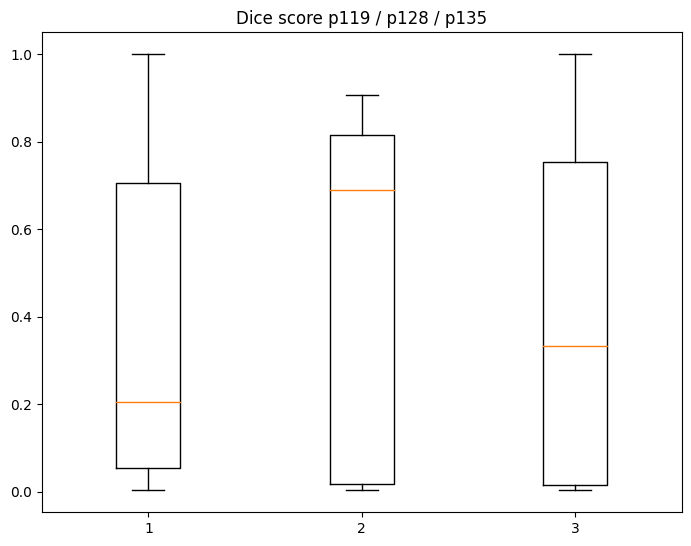

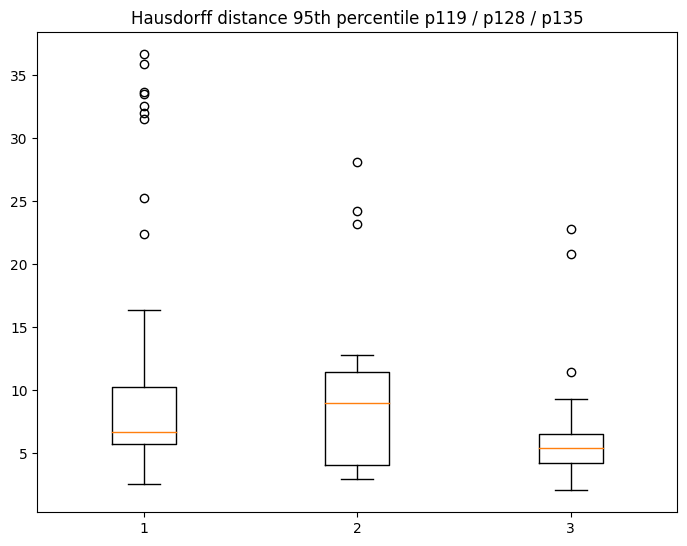

In [69]:
# Create a boxplot for the Dice score and HD
data_dice = [p1_dice_coeffs, p2_dice_coeffs, p3_dice_coeffs]
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(data_dice)
plt.title("Dice score p119 / p128 / p135")
plt.show()

data_HD = [p1_hausdorff_95, p2_hausdorff_95, p3_hausdorff_95]
fig2 = plt.figure()
ax = fig2.add_axes([0, 0, 1, 1])
ax.boxplot(data_HD)
plt.title("Hausdorff distance 95th percentile p119 / p128 / p135")
plt.show()